# Candidate Test 2022 Analysis Part 2

This exercise focuses on the candidate tests from two television networks: DR and TV2. Data from both tests have been given on a scale of five responses (-2, -1, 0, 1, 2). Consider normalizing the data or performing similar scaling transformations as needed.

---

There are 6 datasets included in this exercise:

- `alldata.xlsx`: Contains responses from both TV stations.
- `drdata.xlsx`: Contains responses from DR.
- `drq.xlsx`: Contains questions from DR.
- `tv2data.xlsx`: Contains responses from TV2.
- `tv2q.xlsx`: Contains questions from TV2.
- `electeddata.xlsx`: Contains responses from both TV stations for candidates who were elected to the parliament. Note that 9 members are missing; 7 of them didn't take any of the tests. Additionally, some notable figures like Mette F. and Lars Løkke did not participate in any of the tests.

---

It's entirely up to you how you approach this data, but at a *minimum*, your analysis should include:

- An analysis/description of which questions are most crucial concerning their placement on the axes.
- Average positions of parties concerning each question, preferably with accompanying plots of each (or selected) question.
- A clustering analysis where you attempt various cluster numbers, which would correspond to different parties. Discuss whether there is room for more clusters/parties or if a reduction is needed. Make sure you cover: **K-Means, Hierarchical clustering, and DBSCAN.**
- An overview of the political landscape of the elected candidates, highlighting which members agree or disagree the most and which parties or party members have significant disagreements.
- Feel free to explore further and remember that preprocessing, methodology, and evaluation metrics are not mentioned explicitly, but are implicitly assumed.

---

The following parties are represented:

| Party letter | Party name | Party name (English) | Political position |
| :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left |
| V | Venstre | Danish Liberal Party | Centre-right |
| M | Moderaterne | Moderates | Centre-right |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing |
| D | Danmarksdemokraterne | Denmark Democrats | Right-wing |
| I | Liberal Alliance | Liberal Alliance | Right-wing |
| C | Konservative | Conservative People's Party | Right-wing |
| Æ | Enhedslisten | Red-Green Alliance | Far-left |
| B | Radikale Venstre | Social Liberal Party | Centre-left |
| D | Nye Borgerlige | New Right | Far-right |
| Z | Alternativet | The Alternative | Centre-left |
| O | Dansk Folkeparti | Danish People's Party | Far-right |
| G | Frie Grønne | Free Greens | Centre-left |
| K | Kristendemokraterne | Christian Democrats | Centre-right |

Below you can see the results and the colors chosen to represent the parties. Use these colors in your analysis above.

![Alt text](image-1.png)


Others have undertaken similar analyses. You can draw inspiration from the following (use Google tranlsate if your Danish is rusty):

- [Analysis of where individual candidates stand relative to each other and their parties](https://v2022.dumdata.dk/)
- [Candidate Test 2022 – A deep dive into the data](https://kwedel.github.io/kandidattest2022/)
- [The Political Landscape 2019](https://kwedel.github.io/kandidattest2019/)



In [16]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mglearn
plt.rcParams['image.cmap'] = "gray"

Let's start our analysis by scaling the data using StandardScaler so that it can be used for Principal Component Analysis. We will choose to go with 10 components at the beginning and then we will figure out if we need less by looking at the elbow chart and by printing out the explained variance ratio.

In [17]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
noStringsDf = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

scaler = StandardScaler()
scaler.fit(noStringsDf)
X_scaled= scaler.transform(noStringsDf)

# We choose ten components, but we will adjust that later in the process
pca = PCA(n_components = 10)
pca.fit(X_scaled)
X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))


Original shape: (867, 49)
Reduced shape: (867, 10)


As you can see the data still has 867 rows, but it now has only 10 feautres which were created by the PCA.

In [18]:
import numpy
print(f"The ratio of 10 components: {[round(x, 4) for x in pca.explained_variance_ratio_]}")
print(f"This is how much information is explained in those ten components: {round(numpy.sum(pca.explained_variance_ratio_),4)}")

The ratio of 10 components: [0.4174, 0.1026, 0.0498, 0.043, 0.0293, 0.0237, 0.0199, 0.017, 0.0168, 0.0161]
This is how much information is explained in those ten components: 0.7355


Hmm 73% variance explained in 10 components, that's pretty good result considering that we started with 49 features. Let's have a look at the elbow plot to show that in a different way.

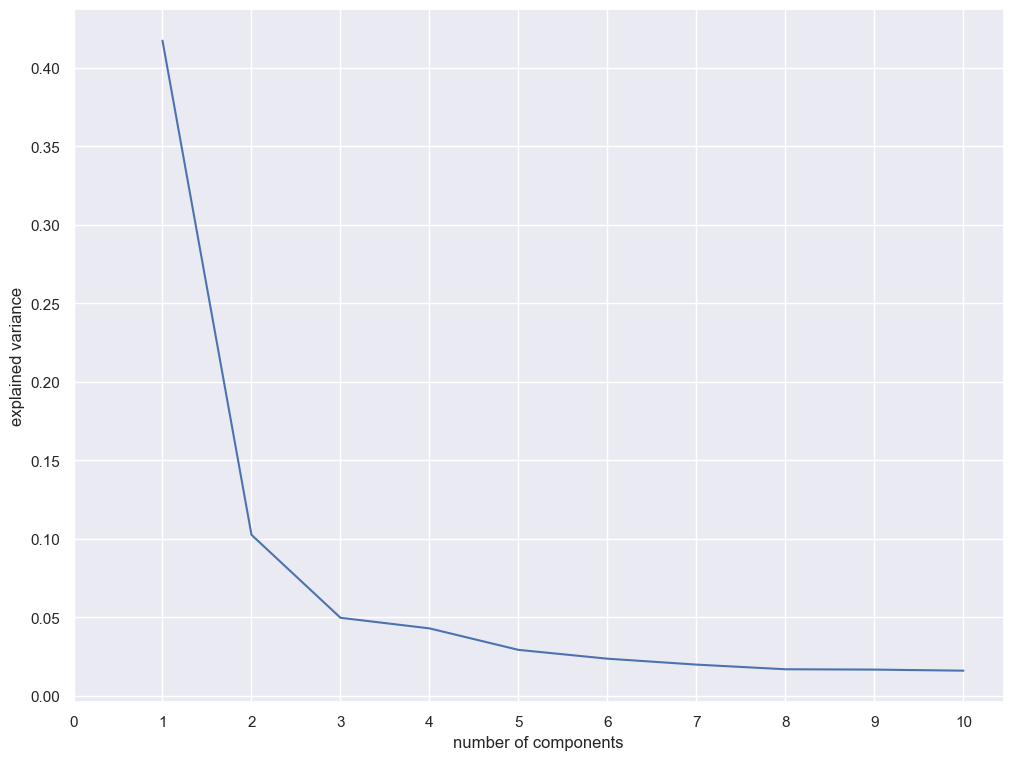

In [19]:
plt.plot(list(range(1, 1 + len(pca.explained_variance_ratio_))), pca.explained_variance_ratio_)
plt.xlabel('number of components')
plt.ylabel('explained variance')
plt.xticks(np.arange(0, 1 + len(pca.explained_variance_ratio_), step=1))
plt.show()

Oh okay, that's look interesting. One can clearly see that the first three components are rather vertical than horizontal, thus they give a lot of value by explaining the variance of the dataset - and as we know variance equals information! We can also see that from 4th component the curve is becoming horizontal so the components do not bring much value. We could try to include only three components, let's see what will be the explained variance ratio for those.

In [20]:
import numpy
pca3 = PCA(n_components = 3)
pca3.fit(X_scaled)
X_pca3 = pca3.transform(X_scaled)
print(f"The ratio of 3 components: {[round(x, 4) for x in pca3.explained_variance_ratio_]}")
print(f"This is how much information is explained in those three components: {round(numpy.sum(pca3.explained_variance_ratio_),4)}")


The ratio of 3 components: [0.4174, 0.1026, 0.0498]
This is how much information is explained in those three components: 0.5697


Well that's a lot of percent but we are also little bit far from the desired 70%. I suppose a better idea would be to include more components, like seven or so. In this case, we will go with 10 as we are not using this on any models. However, if we were to use this on a model, we would definitely try out different number of components to see how it affects my model. Let's say we would start by taking 5 components which explain 70% of the data and see how the model performs. Later we would take 15 components which explain 90% and see if the model slows down or if it is overfitting.

Now we will try to understand what do the first and the second component mean. We will try to find which features from the initial dataset have contributed the most to those components. Moreover, we will try to figure out if they are concering a similar area. Later we will compare that to the political compass - a way to rate political ideology in a spectrum with two axes: one about economic policy and another about social policy. 

In [21]:
components = pca.components_
explained_variance = pca.explained_variance_
feature_names = df.columns

# Print the contribution of each feature to the components
important_features = []
num_features = X_scaled.shape[1]
for i in range(2):
    print(f"Principal Component {i+1}:")
    component_features = [(feature_names[j], components[i][j]) for j in range(num_features)]
    component_features.sort(key=lambda x: abs(x[1]), reverse=True)
    top_5_features = component_features[:5]
    important_features.append(top_5_features)
    for feature, coefficient in top_5_features:
        print(f"{feature}: {coefficient}")


Principal Component 1:
530: -0.19064057260194078
537: 0.190284231801229
3a: -0.1888491516065042
2b: -0.18877782966500675
550: -0.18855512502161118
Principal Component 2:
9b: 0.30291806298749124
556: -0.2979788961106763
551: 0.29383580137686427
553: 0.27280687300299294
3b: 0.25844798965605426


Wow that looks interesting! Now we have the first five questions that had the highest impact on components. Let's see what are those questions.

In [22]:
drq = pd.read_excel('drq.xlsx')
tv2q = pd.read_excel('tv2q.xlsx')

q530 = drq.loc[drq['ID']==530]
q537 = drq.loc[drq['ID']==537]
q550 = drq.loc[drq['ID']==550]
q4a = tv2q.loc[tv2q['id']=='4a']
q3b = tv2q.loc[tv2q['id']=='3b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q530['ID'].iloc[0], q537['ID'].iloc[0], q4a['id'].iloc[0], q3b['id'].iloc[0], q550['ID'].iloc[0]],
    "Area": [q530['Title'].iloc[0], q537['Title'].iloc[0], q4a['header'].iloc[0], q3b['header'].iloc[0], q550['Title'].iloc[0]],
    "Question" : [q530['Question'].iloc[0], q537['Question'].iloc[0], q4a['question'].iloc[0], q3b['question'].iloc[0], q550['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

ID                          Area  \
0  530               KLIMA OG ENERGI   
1  537                       VELFÆRD   
2   4a                       Økonomi   
3   3b  Udenrigs- og forsvarspolitik   
4  550      ARBEJDSMARKED OG ØKONOMI   

                                                                                       Question  
0  Danmark skal bruge flere penge på at styrke tog- og busdrift frem for at bygge nye motorveje  
1      Det er okay, at den økonomiske ulighed stiger, så længe danskerne generelt bliver rigere  
2                                     Den økonomiske ulighed i det danske samfund bør mindskes.  
3                                                                    Ulandsbistanden bør hæves.  
4    Der skal indføres kvoter, der sikrer mindst 30 procent kvinder i virksomheders bestyrelser

### Principal Component 1
**Question ID: 530**   
**Title:** CLIMATE AND ENERGY   
**Description:** Should Denmark prioritize funding for public transportation over new highway construction to address environmental concerns and enhance accessibility?   

**Question ID: 537**   
**Title:** WELFARE   
**Description:** Is it acceptable for economic inequality to increase if the general wealth of Danes also rises?   

**Question ID: 4a**   
**Title:** Economy   
**Description:** Should economic inequality in Danish society be reduced?   

**Question ID: 3b**   
**Title:** Foreign and Defense Policy   
**Description:** Should Denmark increase its foreign aid budget?   

**Question ID: 550**   
**Title:** LABOR MARKET AND ECONOMY   
**Description:** Should there be quotas ensuring at least 30% female representation on company boards?   

The most influencial questions in the first component of PCA are centered around topics such as:
- Economic Policy and Social Inequality:
Economic compensations and retirement policies, accepting rising inequality with increasing general wealth

- Resource allocation:
Goverment investment decisions (public vs private) such as road contruction vs public transportation as well as placement of educational facilities
  
We can clearly see that those question are mostly regarding economics, development and welfare of the Danes. We believe that it fits with the first political compass axes, which is also economics. Let's take a look at the second component.

In [23]:
q556 = drq.loc[drq['ID']==556]
q551 = drq.loc[drq['ID']==551]
q553 = drq.loc[drq['ID']==553]
q10b = tv2q.loc[tv2q['id']=='10b']
q4b = tv2q.loc[tv2q['id']=='4b']

firstComponentQuestions = pd.DataFrame({
    "ID":[q556['ID'].iloc[0], q551['ID'].iloc[0], q10b['id'].iloc[0], q4b['id'].iloc[0], q553['ID'].iloc[0]],
    "Area": [q556['Title'].iloc[0], q551['Title'].iloc[0], q10b['header'].iloc[0], q4b['header'].iloc[0], q553['Title'].iloc[0]],
    "Question" : [q556['Question'].iloc[0], q551['Question'].iloc[0], q10b['question'].iloc[0], q4b['question'].iloc[0], q553['Question'].iloc[0]]
})
pd.set_option('display.max_colwidth', None)     
firstComponentQuestions.head() 

ID                      Area  \
0  556  ARBEJDSMARKED OG ØKONOMI   
1  551            EU OG UDENRIGS   
2  10b             Socialområdet   
3   4b                   Økonomi   
4  553                UDDANNELSE   

                                                                                                                      Question  
0                                                                                     Den såkaldte Arne-pension skal afskaffes  
1                                                             Der skal være permanent grænsekontrol mellem Danmark og Tyskland  
2  Den såkaldte Arne-pension, der giver mulighed for tidligere pension, skal bibeholdes, selvom der er mangel på arbejdskraft.  
3                           Staten bør i højere grad kompensere danskerne for de stigende priser, som inflationen har medført.  
4                                                                Der skal udflyttes flere uddannelsespladser fra de store byer

### Principal Component 2

**Question ID: 556**   
**Title:** LABOR MARKET AND ECONOMY   
**Description:** Should the "Arne pension" be abolished due to its high cost and lack of targeted effectiveness?   

**Question ID: 551**   
**Title:** EU AND FOREIGN AFFAIRS   
**Description:** Should Denmark implement permanent border controls with Germany, potentially impacting Schengen Area commitments?   

**Question ID: 10b**   
**Title:** Social Area   
**Description:** Should the "Arne pension" allowing for early retirement be maintained despite labor shortages?   

**Question ID: 4b**   
**Title:** Economy   
**Description:** Should the state increase compensation to Danes for the rising costs due to inflation?   

**Question ID: 553**   
**Title:** EDUCATION   
**Description:** Should educational opportunities be decentralized from major cities to smaller towns to avoid depopulation?   

The most influencial questions in PCA are centered around topics such as:

- Social equity: incresing diversity in corporate environment 
- National priorities vs global responsibilities: how Denmark manages its own interest in relation to matters like foreign support or border control.

We believe that those questions cover a wide range of social aspects of the Danish community. Therefore, we also think that it fits perfectly with the second axis from the political compass which is social policy. 

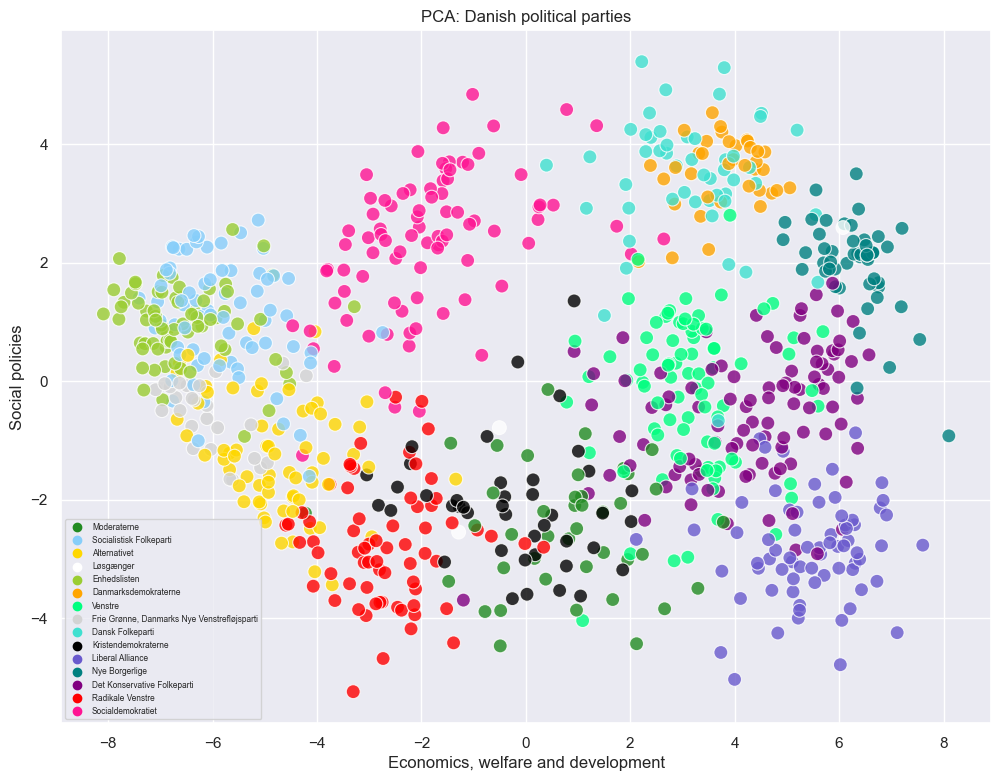

In [24]:
import seaborn as sns

box_colors = ['forestgreen', 'lightskyblue', 'gold', 'white', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

def visualize_2d_pca(x, labels, cols):
    sns.set_theme(rc={'figure.figsize':(12,9)})
    g= sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=cols, s=100, alpha=0.8)
    g.set(xlabel = "Economics, welfare and development")
    g.set(ylabel = "Social policies")
    plt.title("PCA: Danish political parties")
    g.legend(fontsize=6)

visualize_2d_pca(X_pca, labels, box_colors)



Yay, our parties are now all scattered! Upon a quick glance, it looks like the left parties are on the left side and the right parties are on the right side - but just to be sure, let's plot the graph again but color coded this way:

- Right-wing and Far-right parties: Red
- Centre-right parties: Pink
- Centre-left parties: Light blue
- Left-wing parties: Blue

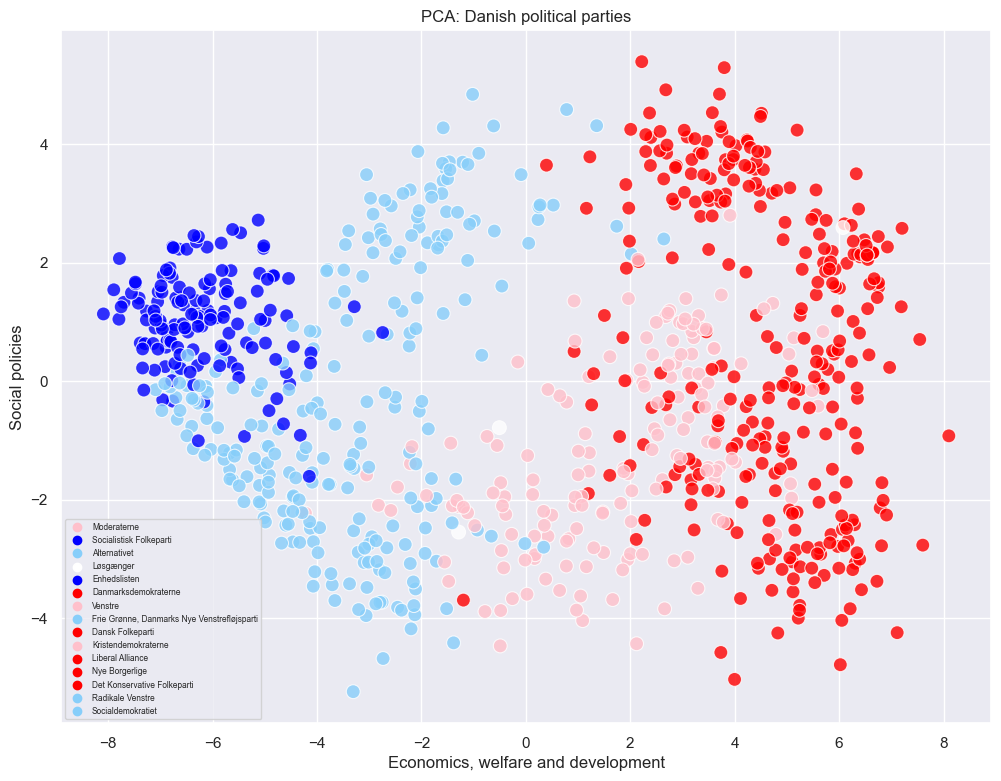

In [25]:
left_right = ['pink', 'blue', 'lightskyblue', 'white', 'blue', 'red', 'pink', 'lightskyblue', 'red', 'pink', 'red', 'red', 'red', 'lightskyblue', 'lightskyblue']
visualize_2d_pca(X_pca, labels, left_right)


Well, isn't that beautiful!!! The left wing parties are on the extreme left side of the plot, the centre-left parties are on the centre-left of the plot, and the inverse applies to centre-right & right parties regarding the right side. This plot aligns perfectly with the political compass. It also shows the beliefs of each party are correctly visualized on the graph. Maybe it could hint that there are too many parties in left wing as well as in the right wing as it is pretty crowded there, meaning that the candidates share similiar opinions while being in different parties. (Let's see what other conclusions we will be able to draw in the clustering step.)

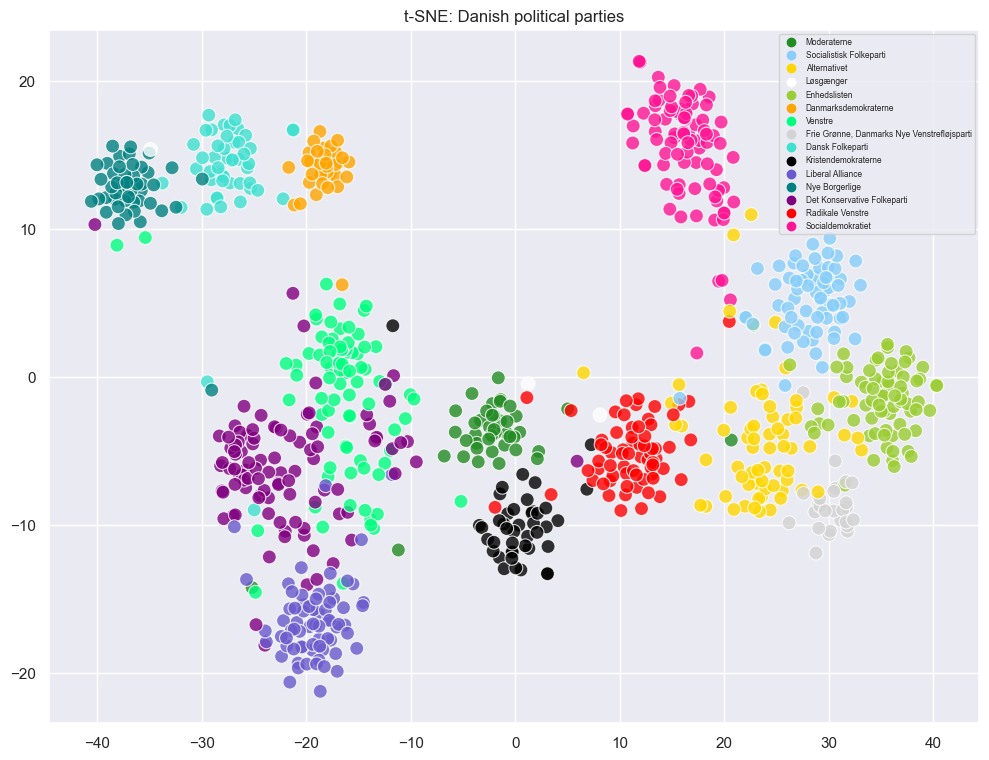

In [26]:
from matplotlib import colors
import seaborn as sns
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=30, random_state=42)
# use fit_transform instead of fit, as TSNE has no transform method
politcal_tsne = tsne.fit_transform(noStringsDf)

def visualize_2d_tsne(x, labels, cols):
    sns.set_theme(rc={'figure.figsize':(12,9)})
    g= sns.scatterplot(x=x[:, 0], y=x[:, 1], hue=labels, palette=cols, s=100, alpha=0.8)
    plt.title("t-SNE: Danish political parties")
    g.legend(fontsize=6)
    
visualize_2d_tsne(politcal_tsne, labels, box_colors)

Here is the result of t-SNE. This algorithm does an outstanding job at grouping the candidates with other candidates of the same party, forming dense groups of data points for each party. The only area where it didn't perform so well was with Det Konservative Folkeparti and Venstre, whose datapoints are a bit mixed and not as dense in the plot.

Looking back at the first part of this assignment, where interparty disagreements were analysed, we can recall that this was the pair of parties that most closely agreed in their answers, among ALL possible pairs of parties. Given that their answers were so similar, it is still very impressive how t-SNE managed to not completely mix them.

Out of curiosity, let's also plot our t-SNE result with the left-right color-coding to see what we will observe.

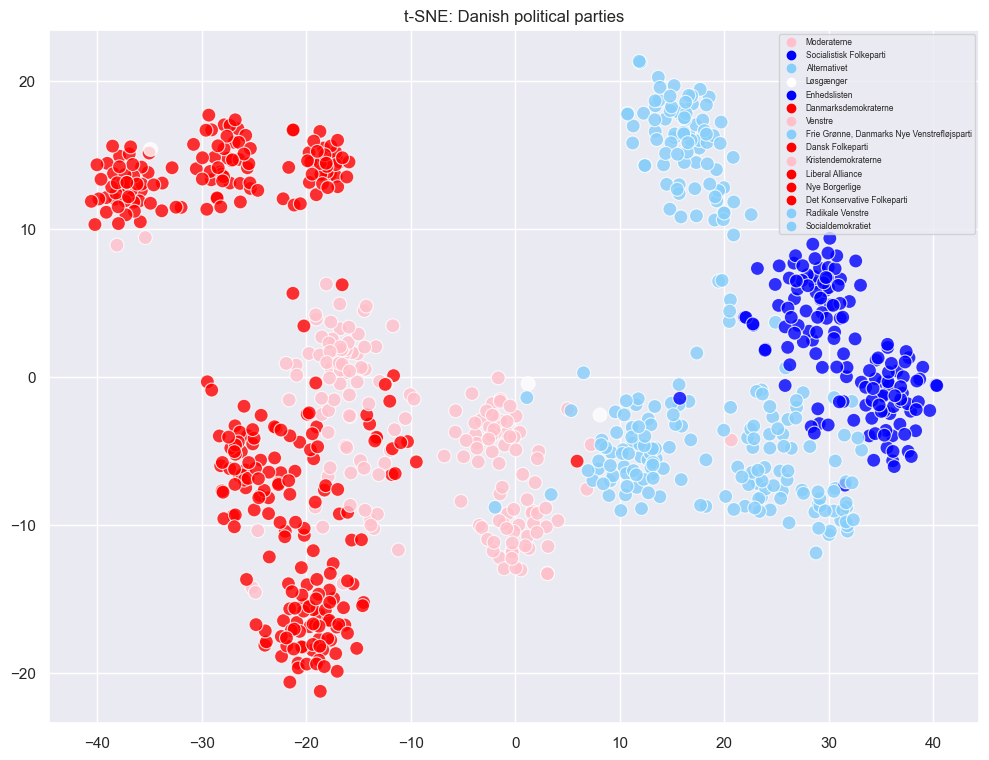

In [27]:
visualize_2d_tsne(politcal_tsne, labels, left_right)

Awesome!!! Just like PCA, t-SNE maintains a good "spatial distribution" among right and left-wing parties, keeping parties of similar ideologies close to each other.

However, something curious to note is that t-SNE groups a certain three right-wing parties with each other, far from the others.

These parties are:

- Nye Borgerlige
- Danske Folkeparti
- Danmarksdemokraterne

The general level of disagreement among these parties, (looking back at the previous part of this assignment), was the following:
- Nye Borgerlige VS Danske Folkeparti: 44/120
- Nye Borgerlige VS Danmarksdemokraterne: 41/120
- Danmarksdemokraterne VS Danske Folkeparti: 32/120

This averages to around 40/120, which is a very low level of disagreement. We can see why t-SNE would "join" these parties in a mini-cloud.

Let's compare these three parties to Liberal Alliance, another right-wing party that did not make it to the "mini cloud" at the top left of the t-SNE chart:

Level of disagreement:
- Liberal Alliance VS Nye Borgerlige: 44/120
- Liberal Alliance VS Danske Folkeparti: 61/120
- Liberal Alliance VS Danmarksdemokraterne: 60/120

The disagreement of Liberal Alliance with the parties of the mini-cloud averages to 55, which is notably higher than within the mini-cloud.

It has been very interesting to compare the outputs of dimensionality reduction with the data we obtained about the interparty disagreements from the first part of this assignment - everything is connected!

# Average positions of parties concering each question

We will now see the average position of each party concerning each question. Of course, there were a lot of questions, so we will only analyze a select few. The questions we will select will be the ones that contributed to the first and second component of PCA.

With the code below, we will visualize each party's average score for each of the questions from components 1 and 2 of PCA.

In [28]:
import pandas as pd
df1 = pd.read_excel('alldata.xlsx')
# let's create two lists containing the questions IDs corresponding to PC1 and PC2
# creating a df 'relevant data' containing party name and both PC1 and PC2 questions.
questions_pc1 = ['530', '537', '4a', '3b', '550']
questions_pc2 = ['10b', '556', '551', '553', '4b']
relevant_questions = questions_pc1 + questions_pc2
relevant_data = df1[['parti'] + relevant_questions]

# calculating the average response for each PC questions. 
average_positions_pc1 = relevant_data.groupby('parti')[questions_pc1].mean()
average_positions_pc2 = relevant_data.groupby('parti')[questions_pc2].mean()

average_positions_pc1, average_positions_pc2

(                                                  530       537        4a  \
 parti                                                                       
 Alternativet                                 1.880597 -1.641791  1.746269   
 Danmarksdemokraterne                        -0.837838  0.189189  0.108108   
 Dansk Folkeparti                            -0.571429  0.000000  0.448980   
 Det Konservative Folkeparti                 -0.836735  1.408163 -0.948980   
 Enhedslisten                                 1.959459 -1.878378  2.000000   
 Frie Grønne, Danmarks Nye Venstrefløjsparti  1.923077 -2.000000  2.000000   
 Kristendemokraterne                          0.880952 -0.428571  0.738095   
 Liberal Alliance                            -1.142857  1.900000 -1.628571   
 Løsgænger                                    0.000000  0.666667  0.666667   
 Moderaterne                                  0.642857  0.619048  0.095238   
 Nye Borgerlige                              -1.098039  1.705882

But that's just a whole lot of numbers, so it doesn't tell us much. With that in mind, let's plot them!!

A first step could be to make a function that plots all parties' average positions when given a question.

In [29]:
import seaborn as sns
# creating a function plot_average_positions that takes questions data and plots it with a title
def plot_average_positions(question_data, title):
    plt.figure(figsize=(16, 10))
    sns.barplot(data=question_data.T)
    plt.title(title)
    plt.ylabel('Average Position')
    plt.xlabel('Questions')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

Perfect! The code below will now iterate through both PC1 and PC2 questions and show their graphs in the output below.

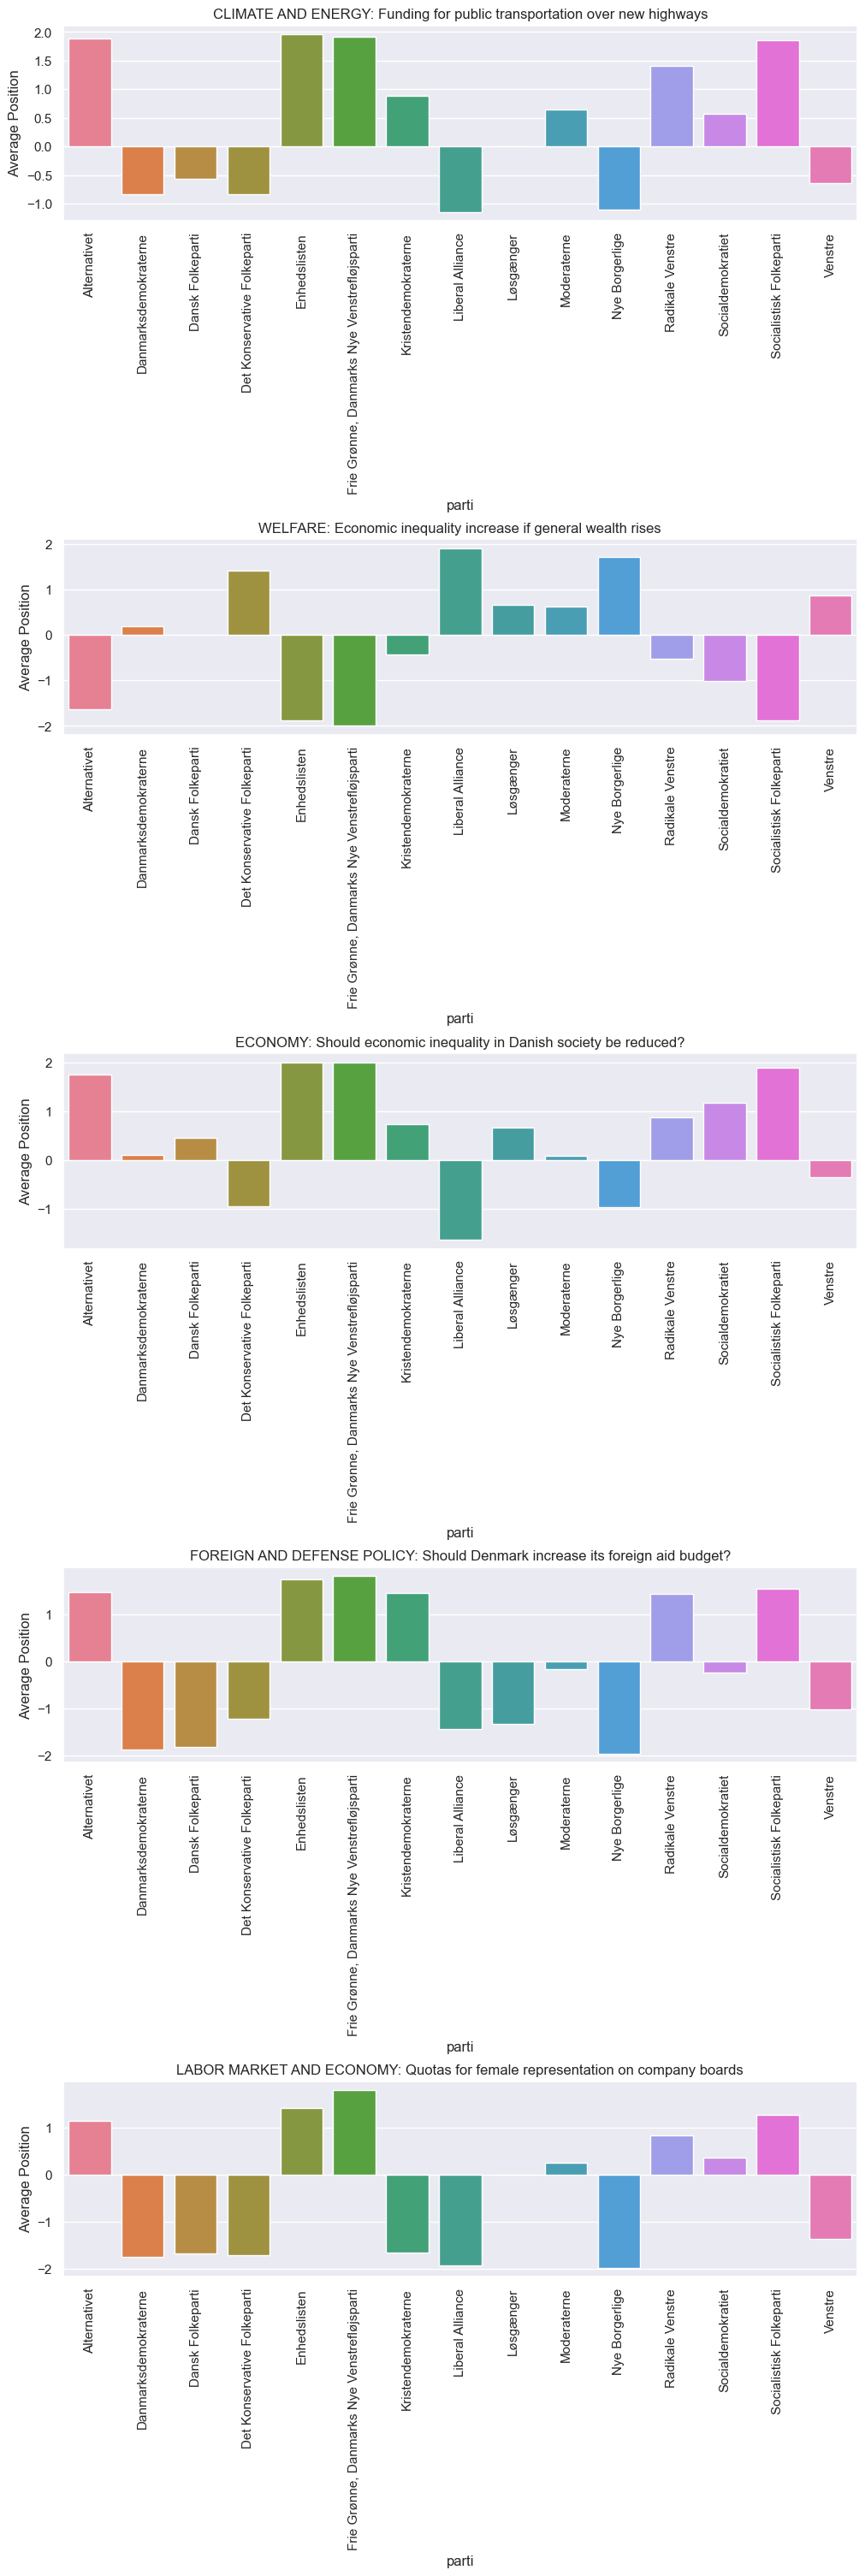

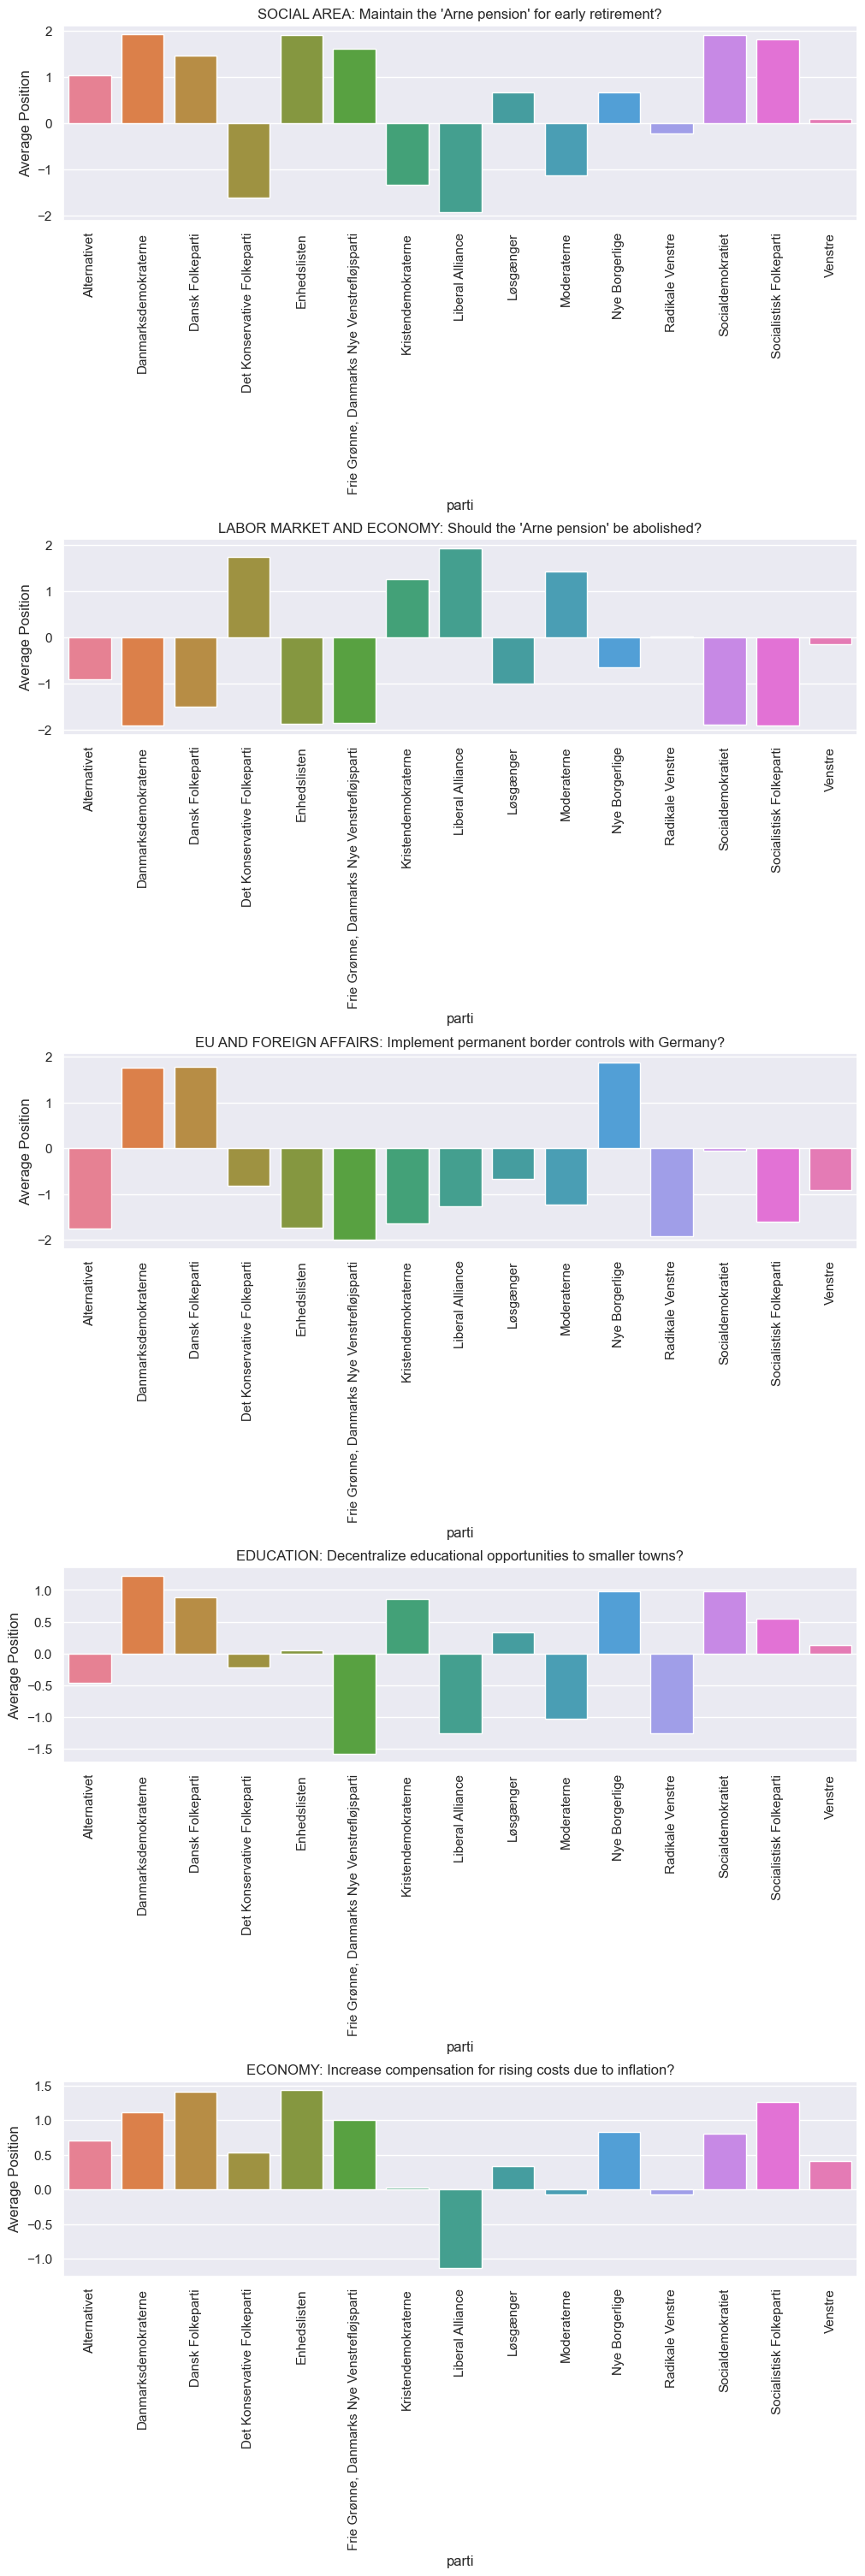

In [30]:
# we want to have 5 rows and 1 column graphs
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 30), constrained_layout=True)

#this palette will make the graph more diversed in terms of colors in comparison with default sns tone.
palette = sns.color_palette("husl", len(relevant_data['parti'].unique()))

# titles and questions strings for the graph ( PC1 )
titles_pc1 = [
    "CLIMATE AND ENERGY: Funding for public transportation over new highways",
    "WELFARE: Economic inequality increase if general wealth rises",
    "ECONOMY: Should economic inequality in Danish society be reduced?",
    "FOREIGN AND DEFENSE POLICY: Should Denmark increase its foreign aid budget?",
    "LABOR MARKET AND ECONOMY: Quotas for female representation on company boards"
]

# plotting the graphs
for ax, question_id, title in zip(axes.flat, questions_pc1, titles_pc1):
    sns.barplot(ax=ax, data=relevant_data.groupby('parti')[question_id].mean().reset_index(), x='parti', y=question_id, palette=palette)
    ax.set_title(title)
    ax.set_ylabel('Average Position')
    #ax.set_xlabel('Party')
    ax.tick_params(axis='x', rotation=90)

plt.show()

# again, we want to have 5 rows and 1 column graphs
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 30), constrained_layout=True)

# titles and questions strings for the graph ( PC2 )
titles_pc2 = [
    "SOCIAL AREA: Maintain the 'Arne pension' for early retirement?",
    "LABOR MARKET AND ECONOMY: Should the 'Arne pension' be abolished?",
    "EU AND FOREIGN AFFAIRS: Implement permanent border controls with Germany?",
    "EDUCATION: Decentralize educational opportunities to smaller towns?",
    "ECONOMY: Increase compensation for rising costs due to inflation?"
]

# plotting the graphs
for ax, question_id, title in zip(axes.flat, questions_pc2, titles_pc2):
    sns.barplot(ax=ax, data=relevant_data.groupby('parti')[question_id].mean().reset_index(), x='parti', y=question_id, palette=palette)
    ax.set_title(title)
    ax.set_ylabel('Average Position')
    #ax.set_xlabel('Party')
    ax.tick_params(axis='x', rotation=90)

plt.show()

That's a lot to look through, but how beautiful!

Particularly for the Principal Component 1, we see that the Right-wing and Left-wing parties are always a mirror of each other when it comes to the score for each question.

For example, if we look at:

**(left parties):**
- Socialistik Folkeparti
- Enhedslisten
- Frie Grønne 

We see that their average answers are almost always extremely similar...

And if we look at:

**(right parties)**
- Nye Borgerlige
- Danske Folkeparti
- Danmarksdemokraterne

We observe exactly the same phenomenon as those three left parties, except on the "flip-side" of the graph. And it is worth noting that the "mini-cloud" formed by t-SNE was composed of these exact three parties! So everything comes together nicely - we can see how similar they scored on the two principal components based on these graphs we just plotted.

It's also very interesting to observe the difference in "variation" that is evident between the questions of PC1 and PC2. We see that PC1 is in first place for a reason - the average score of these five questions are the ones that varies the most among all parties - each score very different from the other, always ranging from very low negative values to very high positive values.

Then, when looking down to the PC2 questions, there is still a high degree of variation, but not quite as much as for PC1 (for example, in the last question, almost all of the parties had a positive score, with only Liberal Alliance being the "black sheep" in the negative area.)

Seeing these graphs emphasizes the value that comes from the variation "found" in these questions by the Principal Component Analysis!

And also sets a good precedent for clustering! In this exercise, we were looking at the average score of all candidates of one party (so they are all "joined"), whereas, in clustering, we are grabbing each individual candidate and clustering them based on their answers. This means... that if the parties have very coherent answers, that the clusters will likely be good, but if the parties have very diverging answers to the questions, that candidates might get "misplaced". We are also curious to observe if the parties with a similar average score for most questions will be placed close to each other in the clustering graphs!!

Let's see.

# CLUSTERING

Now that we have reduced the dimensionality of our dataset in two different ways, it's time to experiment with some clustering!!!!

We will go through all three clustering algorithms we know (k-means, Hierarchical Clustering, DBSCAN) for both our data reduced with PCA and t-SNE, and see what interesting conclusions we can reach from this unsupervised approach :).

## k-means clustering

We will first evaluate the elbow chart for the cost function for both the data reduced with PCA and with t-SNE to see what could be an appropriate number of clusters.

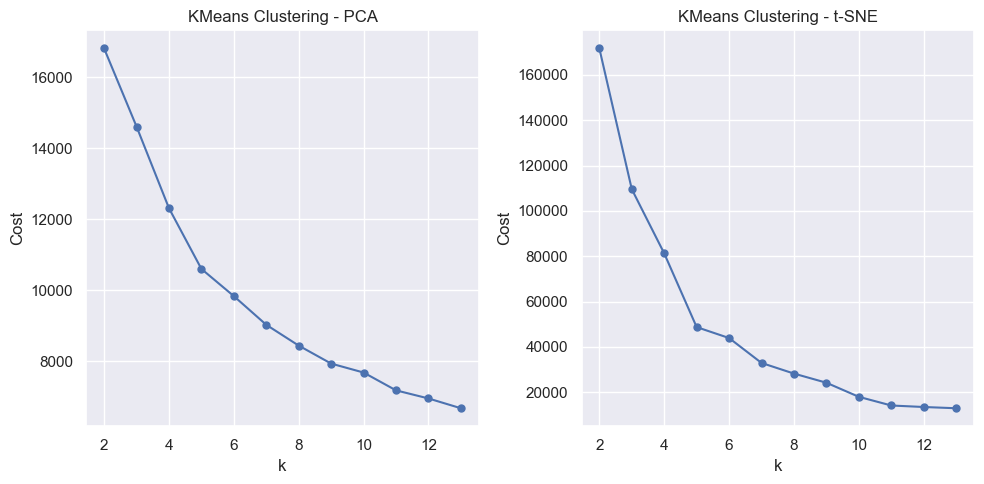

In [31]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# code taken from slides :D

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create two subplots side by side

for i, X in enumerate([X_pca, politcal_tsne]):  # Loop over the two datasets
    ax = axes[i]  # Select the current axis

    costs = []
    ks = range(2, 14)
    for k in ks:
        kmeans = KMeans(n_clusters=k, n_init='auto')
        kmeans.fit(X)
        costs.append(kmeans.inertia_)

    ax.plot(ks, costs, '.-', markersize=10)
    ax.set_xlabel('k')
    ax.set_ylabel('Cost')
    if (i == 0):
        ax.set_title(f'KMeans Clustering - PCA')
    if (i == 1):
        ax.set_title(f'KMeans Clustering - t-SNE')
    

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

For both reducted datasets, it looks like 5 or 6 can be a good number of clusters! It should be noted that these graphs look different every time we run the code block, given the random nature of k-means clustering. Sometimes, the cost even goes up when moving the number of neighbours up by one step, which looks really odd. We would assume that this happens when the initial centroids end up in an unfavourable random initial position for the clustering. The next step is to visualize the clusters and draw conclusions.

Let's first draw the graphs with 5 clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


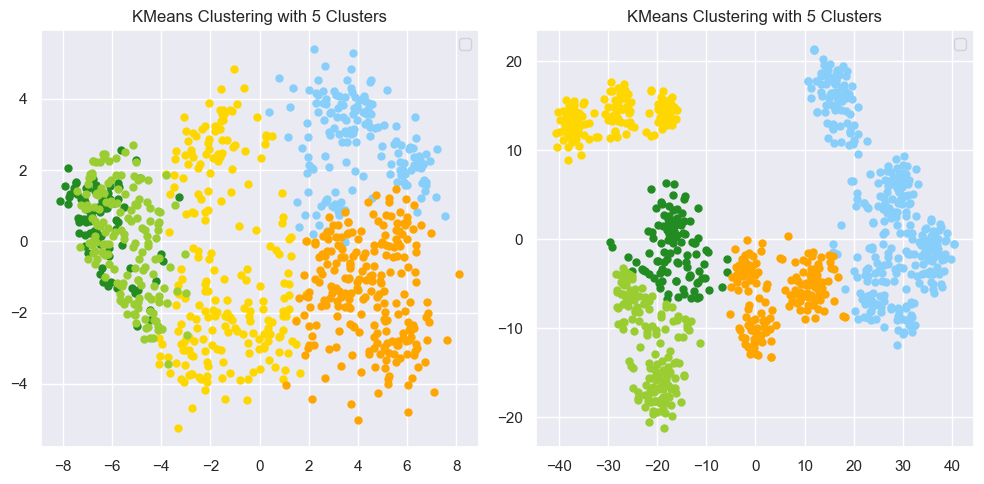

In [32]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def plot_k_means(datasets, num_clusters, colors=None):
    fig, axes = plt.subplots(1, len(datasets), figsize=(5 * len(datasets), 5))

    for i, (X, k) in enumerate(zip(datasets, num_clusters)):
        ax = axes[i] if len(datasets) > 1 else axes  # Handle single subplot case

        kmeans = KMeans(n_clusters=k, n_init='auto')
        labels = kmeans.fit_predict(X)

        # Plot data points for each cluster
        for cluster in range(k):
            if colors:
                color = colors[cluster % len(colors)]  # Cycle through colors if fewer than k provided
            else:
                color = None  # Let matplotlib choose the color
            ax.plot(X[labels == cluster, 0], X[labels == cluster, 1], '.', markersize=10, color=color)

        ax.set_title(f'KMeans Clustering with {k} Clusters')
        ax.legend()

    plt.tight_layout()
    plt.show()


cols = ['forestgreen', 'lightskyblue', 'gold', 'yellowgreen', 'orange', 'springgreen', 'lightgray','turquoise', 'black', 'slateblue', 'teal','purple', 'red',  'deeppink']

plot_k_means([X_pca, politcal_tsne], [5,5], cols)

These clusters look pretty good, but on both sides, it is somewhat evident that one of the clusters is far larger than the others - this means that perhaps increasing k by 1 is worth it. Let's see the output when we use 6 as our number of clusters.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


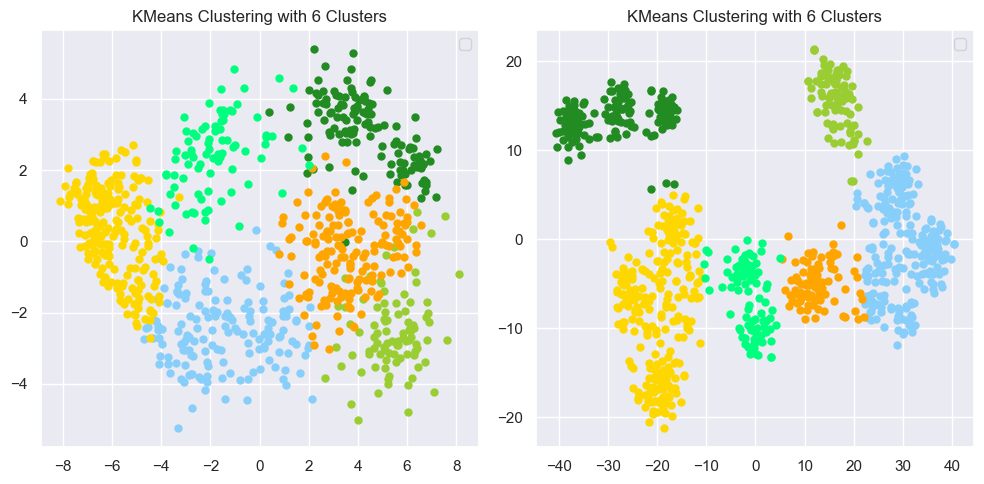

In [33]:
plot_k_means([X_pca, politcal_tsne], [6,6], cols)

Now that looks pretty good! All clusters are of a similar size on both sides. Having seen this, we would say that, according to this combination of PCA and k-means clustering, the economical and social profile of Denmark's politicians can be partitioned into 6 groups (since PCA's main components were economics and social policies.)

However, it should be noted that significantly different results come from running k-means different times, so this algorithm might not be ideal for the data that we have. For example, the "mini-cloud" of right-wing parties we discussed earlier is sometimes split by k-means even though it is a very cohesive unit.

Comparing these graphs to the "left-right color-coded" ones we got earlier, we would say:
- for the PCA graph, that k-means is fairly good at separating general tendencies of parties, because it formed clusters made up mostly of one political tendency (f.x. mostly left-wing, mostly right-wing, mostly centre-left)
- for the t-SNE graph, it was a bit weak since it sometimes separated cohesive clusters (particularly, the mini-cloud). Still, it never mixed left-wing data points with right-wing, so it still did a decent job at forming clusters with the same political tendencies.

Out of curiosity, let's plot different numbers of neighbours as well.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


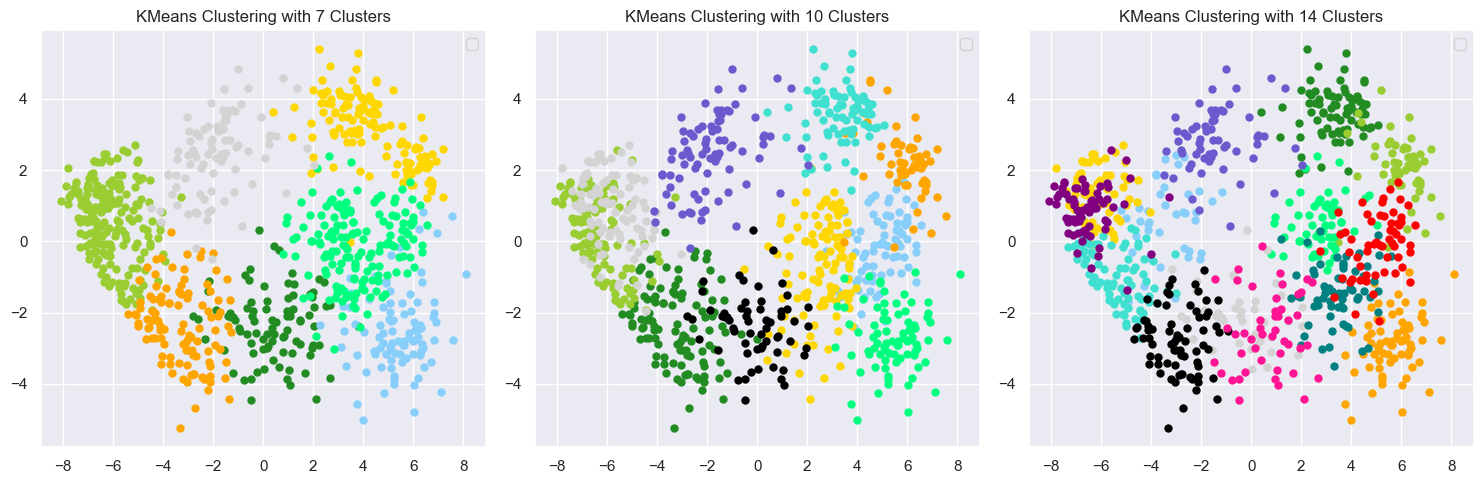

In [34]:
plot_k_means([X_pca, X_pca, X_pca], [7,10,14], cols)

Anything over 7 clusters is lousy for PCA - the clusters, no matter how many retries, merge more into each other the more clusters we introduce. 5-7 was indeed the sweet spot. 

When we give k-means the "real" number of parties (14, on the right side) and compare it with our eyes to the original labeled graph, we see that it managed to cluster some parties very closely to their original distribution (Nye Borgerlige, Liberal Alliance, Socialitisk Folkeparti, Venstre, Radikale Venstre), while some other parties were completely scattered (Det Konservative Folkeparti), or k-means joined two parties that were not meant to be together (for example, Dansk Folkeparti and Danmarksdemokraterne, two parties who had a high level of agreement).

However, what we wrote above might not even apply 100% when one reads this text due to the random nature of k-means and the possibility of the code having been reran since this paragraph was written. Because this algorithm's output is so variable with this type of data distribution, we conclude that k-means is not a good clustering algorithm for our candidates who had their dimensionality reduced by PCA.

Let's see what we can get out of adding more clusters to t-SNE. Since t-SNE already reduced the dimensionality of the dataset by "grouping" close together similar candidates, for this one analysis we are going to try to use a number of clusters closer to the total number of parties (14). So, 12, 14 and 16.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


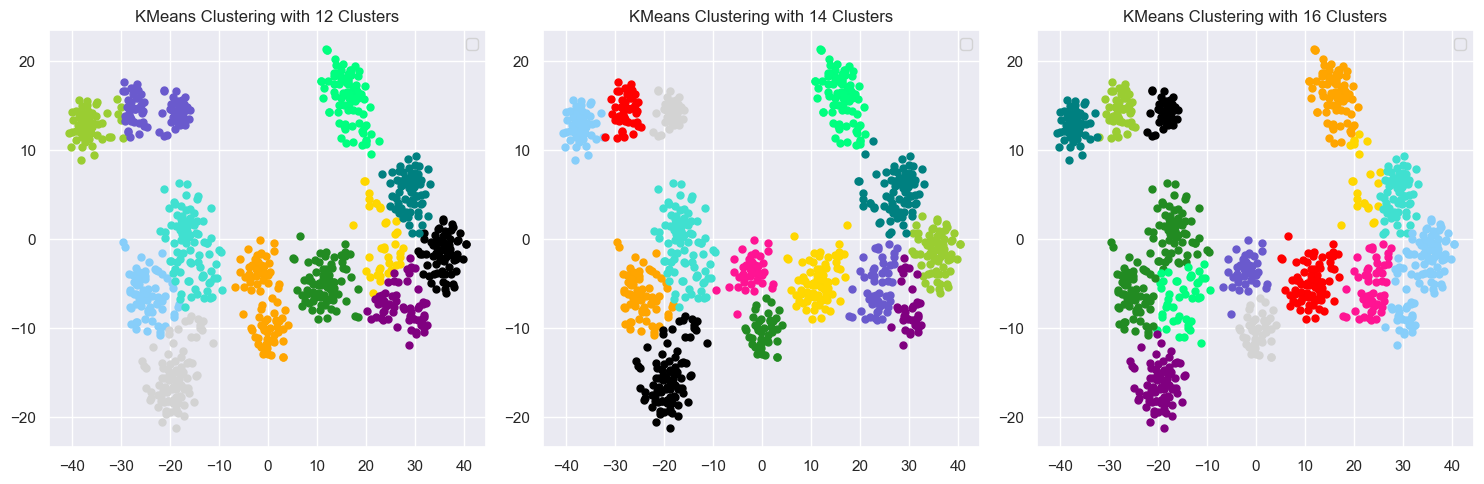

In [35]:
plot_k_means([politcal_tsne, politcal_tsne, politcal_tsne], [12,14, 16], cols)

After a couple of tries to get a decent k-means separation, we can see that:
- With 12 clusters, there are still some groups of points that could have been split further when considering the t-SNE data visualization.
- With 14 clusters, the separation is very good most of the time.
- 16 clusters might be overkill since then there are clusters that are extremely scarce, or split in half, leading us to conclude that 14 was indeed the sweet spot.


However, it is also worth comparing the clustering done on top of the unlabeled t-SNE data to the labeled t-SNE data, side by side.

/Users/laura/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


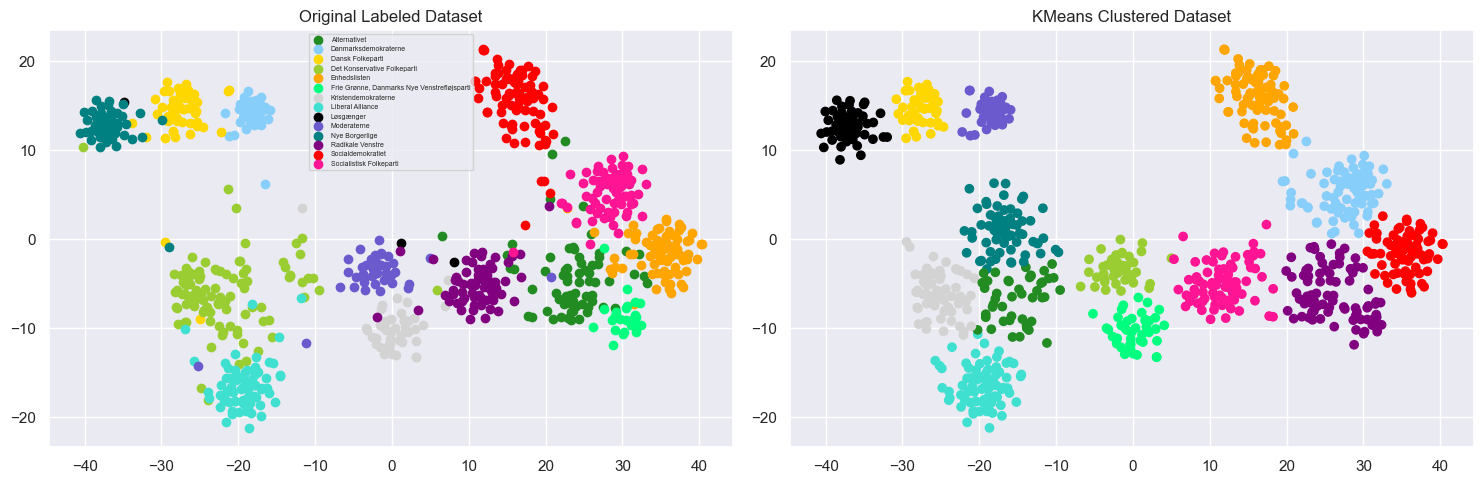

In [36]:
import matplotlib
import sklearn.preprocessing
df = pd.read_excel('alldata.xlsx')
df = df.dropna()
labels = df['parti']
noStringsDf = df.drop(columns=['storkreds', 'alder', 'navn', 'parti'])

scaler = StandardScaler()
scaler.fit(noStringsDf)
X_scaled= scaler.transform(noStringsDf)

def plot_labeled_vs_kmeans(X, original_labels, num_clusters, original_colors=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot original labeled dataset
    ax1 = axes[0]
    for label, color in zip(np.unique(original_labels), original_colors):
        ax1.scatter(X[original_labels == label, 0], X[original_labels == label, 1], label=label, color=color)
    ax1.set_title('Original Labeled Dataset')
    ax1.legend(fontsize=5)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters)
    cluster_labels = kmeans.fit_predict(X)

    # Plot KMeans clustered dataset
    ax2 = axes[1]
    if colors:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=matplotlib.colors.ListedColormap(original_colors))
    else:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='idk')
    ax2.set_title('KMeans Clustered Dataset')

    plt.tight_layout()
    plt.show()


plot_labeled_vs_kmeans(politcal_tsne, labels, 14, cols)

How curious :) with t-sne, K-means clustering joins the candidates without mixing them at all (right side picture), whereas the original dataset has a bit of "mixing" involved among candidates, some of them going pretty far away from their original party. However, there is one cluster that k-means couldn't identify no matter the number of tries (the one on the left side graph at (x=30, y=-10, in bright green)). Maybe this party should dissolve and merge with the "dark green" party, as proposed by k-means.

(These two parties that k-means suggests a merge would be Alternativet and Frie Grønne, both Center-Left parties. When looking back at assignment number 2, it is worth recalling that these two parties also had an extremely low level of interparty disagreement here. So this clustering analysis further reinforces the idea that they could merge pretty seamlessly :).

We also see that what is, on the right side, a party (around x=-10, y=-5) that is just kind of a mix between the parties on the left side at (x=-25, y=5) and (x=-5, y=0). These parties are Det Conservative Folkeparti and Venstre - who, on the first assignment, were the pair of parties closest to each other in terms of similar answers - so it is no surprise that they would also stay close after a t-SNE dimensionality reduction, so much that the "scattered points between them" could be deemed as another cluster.

**K-means summary!!**

In summary, our analysis using the K-means clustering algorithm has led us to conclude that:
- When looking at the political parties only from the economical & social perspective (PCA dim. reduction), we can only really split them into around 6 groups - these groups very accurately represent the cluster's political tendencies (fx left-wing, right-wing, centre-right, etc.)
- When using t-SNE to try to form clusters, we see that, according to this algorithm of dimensionality reduction, there is still enough tangible difference among parties for us to be able to separate the candidates into 14 solid clusters with k-means, the same number as the parties that actually exist. The clustering resulting from the combination of t-SNE and K-means is considerably similar to the original "distribution" of candidates! Meaning that t-SNE did an extraordinary job at reducing the dimensionality without disrupting potential "grouping" of candidates!

## Agglomerative clustering

Let's move on to Agglomerative Clustering!
When doing this, it's always a good idea to start by drawing the histogram and see what could be the optimal number of clusters for this algorithm.

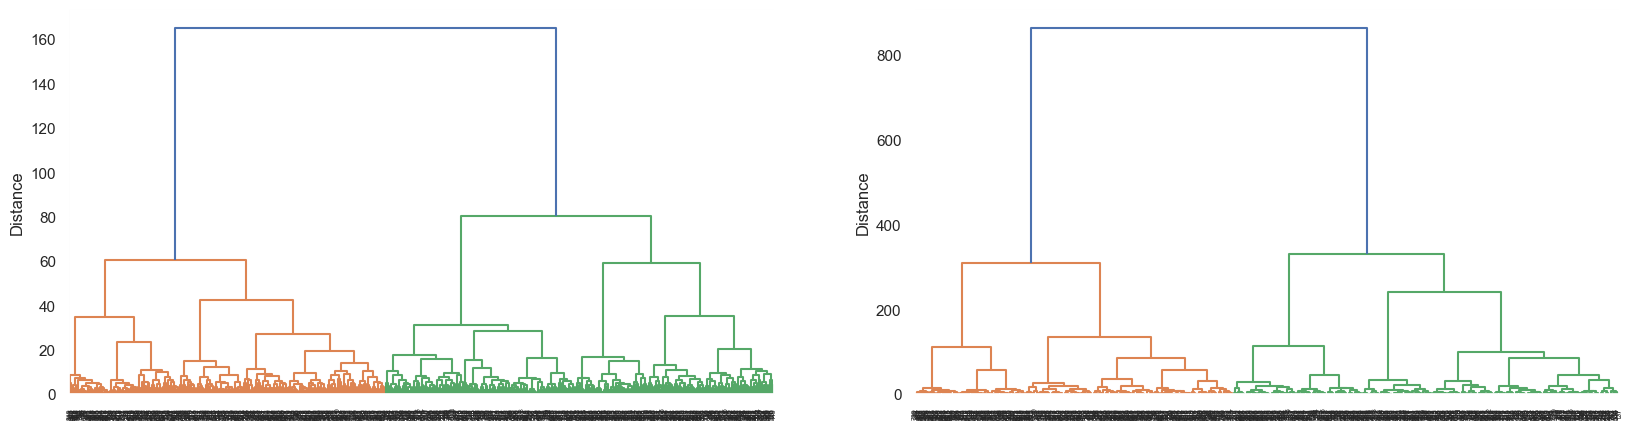

In [37]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward

# code taken from slides and slightly modified
def plot_dendrogram(X1, X2):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    X_list = [X1, X2]
    for i, ax in enumerate(axes):
        linkage_array = ward(X_list[i])  # compute distances using Ward's method
        dendrogram(linkage_array, ax=ax)
        ax.set_ylabel('Distance')
    plt.show()


plot_dendrogram(X_pca, politcal_tsne)

It looks like the longest vertical segment without any merging, for both cases, is 2... So let's first see what two clusters we get when we apply Agglomerative Clustering with this number.

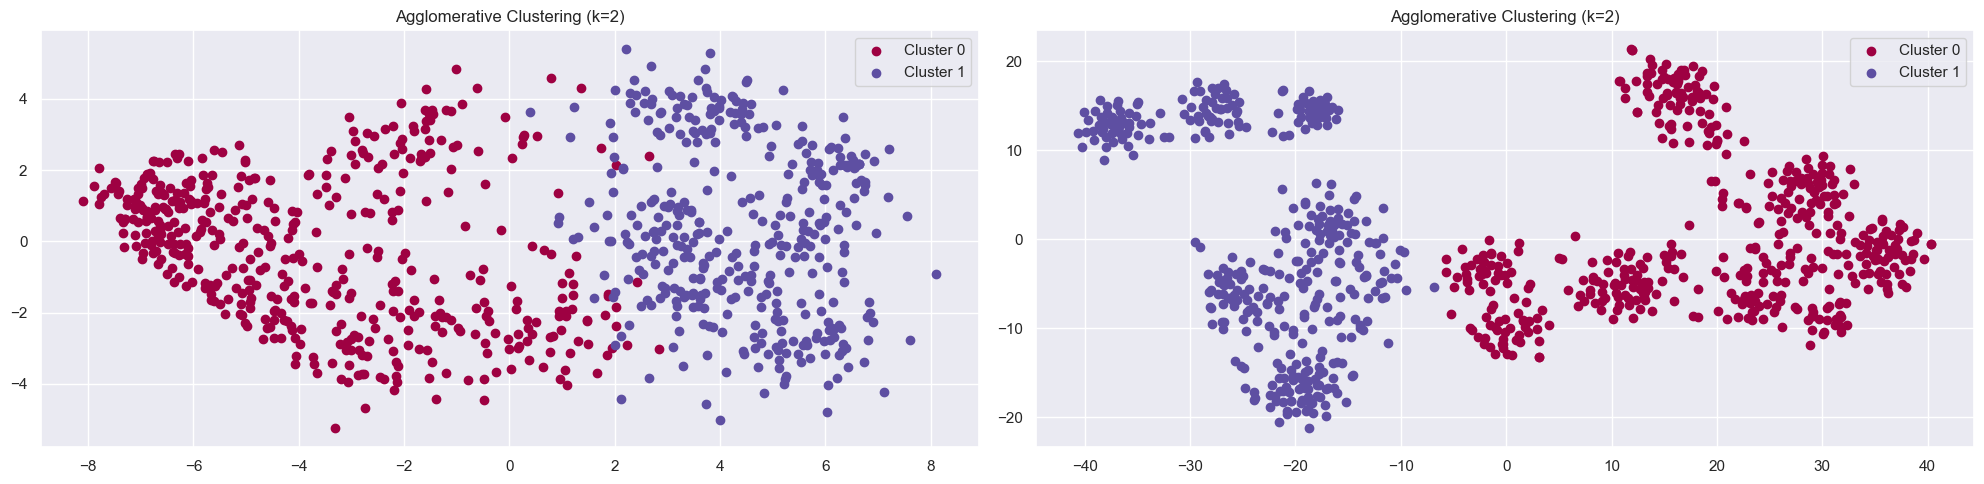

In [38]:
def plot_agg_clustering(ks, method):
    fig, axes = plt.subplots(1, 2, figsize=(20, 5))
    exes = [X_pca, politcal_tsne]

    for i, (X, ax) in enumerate(zip(exes, axes)):
        agg = AgglomerativeClustering(n_clusters=ks[i], linkage=method)
        labels = agg.fit_predict(X)
        
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
        
        for cluster_label, color in zip(unique_labels, colors):
            cluster_points = X[labels == cluster_label]
            ax.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=f'Cluster {cluster_label}')
        
        ax.set_title(f'Agglomerative Clustering (k={ks[i]})')
        ax.legend()
    
    plt.tight_layout()
    plt.show()
    
plot_agg_clustering([2,2], 'ward')



When using two clusters, Agglomerative Clustering separates the PCA data by the first component - which makes sense because it's the most "descriptive" one.
Comparing it to the color-coded left-vs-right plot we got when doing PCA, we see that Agglomerative Clustering actually very accurately split all political parties into Left VS Right tendencies! The only data points it missed were a few in the center - it suggested that some candidates who were centre-right should actually belong to the left side of the political compass. But overall, not bad at all!!! It even accurately caught a couple "strays" from the left-side that are closer to the right side on the graph.

As for the t-SNE data, the result of Agglomerative Clustering was overall very good, but it "misplaced" a centre-right party into the left-side as well. (The one at (x=0 and y=-5)).

This might be worth taking a closer look. Could it be that the party that was misplaced in the PCA and in t-SNE was the same one?!

Party displaced in PCA graph: Kristendemokraterne, Moderaterne (centre-right parties that got grouped with the left-side parties)
Party displaced in t-SNE graph: Kristendemokraterne, Moderaterne (centre-right parties that got grouped with the left-side parties)

Incredible!!!!!!

It seems that, no matter the dimensionality reduction followed, agglomerative clustering deems Kristendemokraterne and Moderaterne as being closer to the left-side parties, if it had to choose one side.

Looking back at the first part of this assignment, we recall that these two parties were the ones with the most significant internal disagreement, particularly Kristendemokraterne.

Knowing that, we can say that maybe there are political candidates from Kristendemokraterne & Moderaterne that might want to switch to the left-side...

Let's see what happens when we use the "second-best" option of number of clusters for each data set - 4 for PCA and 5 for t-SNE.

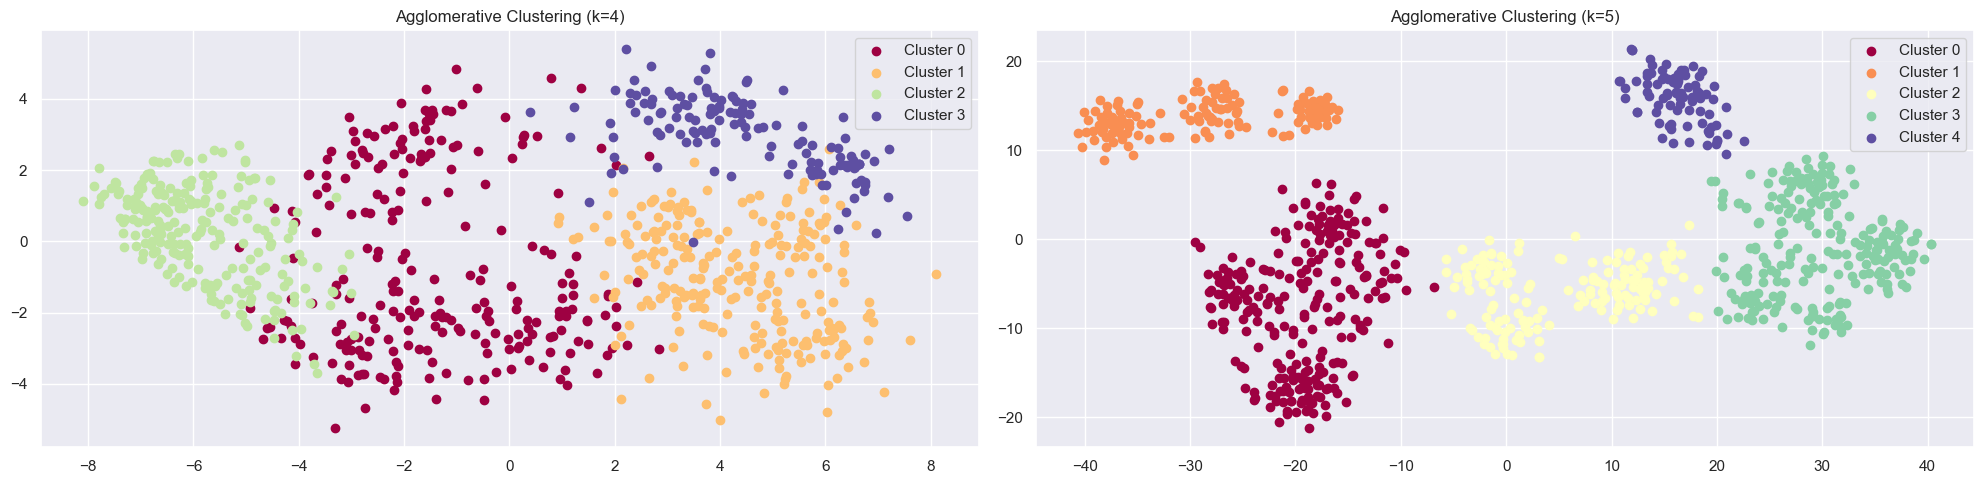

In [39]:
plot_agg_clustering([4,5], 'ward')

When choosing 4 clusters, we see that, for PCA, the second component starts to come more into play.
We have:
- A cluster on the left side with extreme economical views and similar social duty views (which is a near perfect match with the left-wing parties)
- A cluster on the left-center with milder economical views and varying social duty views (which is a near perfect match with centre-left parties, except it's still encompassing Kristendemokraterne & Moderaterne to some degree!!)
- A cluster on the right-bottom side with right-side economical views and a broad range of social duty views excluding extremely authoritarian views (which encompasses both a lot of centre-right and right-wing parties)
- A cluster on the top-right with right-side economical views and extremely authoritarian social duty views (corresponding to Dansk Folkeparti, Danmarksdemokraterne and Nye Borgerlige... THE SAME AS THE MINI-CLOUD IN T-SNE!)

As for t-SNE, we see that Agglomerative Clustering, given only 5 clusters, grouped:

- Nye Borgerlige, Dansk Folkeparti and Danmarksdemokraterne **(Far-right or right-wing)**
- Liberal Alliance, Det Konservative Folkeparti, Venstre **(Right-wing or centre-right)**
- Kristendemokraterne, Moderaterne, Radikale Venstre **(Centre-right or centre-left)**
- Socialdemokratiet **(Centre-left)**
- Alternative, Frie Grønne, Enhedslisten, Socialitisk Folkeparti **(Centre-left, left wing or far-left)**

Which is interesting to observe because they kind of "gradually" go from left to right politically.

Seeing how Agglomerative Clustering handles 4-5 clusters was sooooo interesting. Even if the "mini-cloud" of political parties formed by t-SNE doesn't look as evident on the PCA graph with our "naked eye", Agglomerative Clustering still made them into a separate cluster!! And with both graphs, Agglomerative Clustering considers Kristendemokraterne and Moderaterne to be kind of ambiguous parties that can swing either left or right, so they are a bit "on the limbo".

Agglomerative Clustering did a very good job at forming clusters for extreme-left for PCA, but not so much for extreme-right, and not so much for either extreme of the spectrum in t-SNE - only the "mini-cloud". (In other words, Agglomerative Clustering didn't manage to fully and accurately isolate the far-right and left-wing parties from the centre-right and centre-left).

Let's try comparing the agglomerative cluster's behaviour with 14 clusters to the original labeled data, for both PCA and t-SNE.


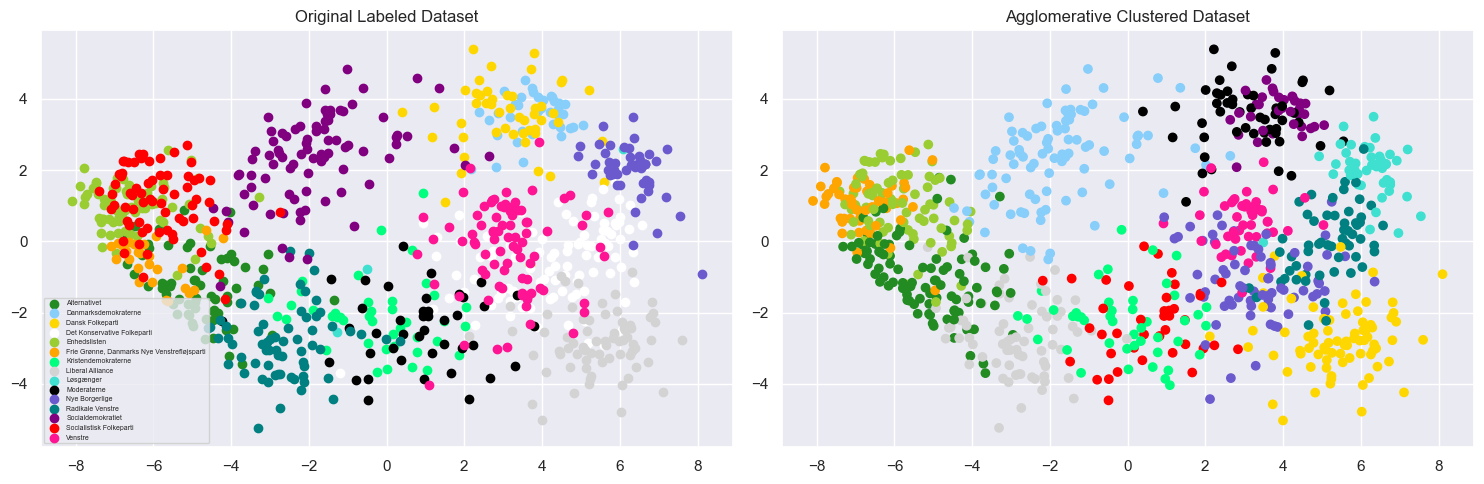

In [40]:
def plot_labeled_vs_agg(X, original_labels, num_clusters, method='ward', original_colors=box_colors):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot original labeled dataset
    ax1 = axes[0]
    for label, color in zip(np.unique(original_labels), original_colors):
        ax1.scatter(X[original_labels == label, 0], X[original_labels == label, 1], label=label, color=color)
    ax1.set_title('Original Labeled Dataset')
    ax1.legend(fontsize=5)

    # Perform Agglomerative clustering
    agg = AgglomerativeClustering(n_clusters=num_clusters, linkage=method)
    cluster_labels = agg.fit_predict(X)

    # Plot Agglomerative clustered dataset
    ax2 = axes[1]
    if colors:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap=matplotlib.colors.ListedColormap(cols))
    else:
        ax2.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='idk')
    ax2.set_title('Agglomerative Clustered Dataset')

    plt.tight_layout()
    plt.show()


plot_labeled_vs_agg(X_pca, labels, 14, 'ward')

Sure, the colors on each graph are different, but inspecting closely, we can say that the Agglomerative Clustering did an OUTSTANDING job at finding actual patterns that distinguish parties from each other despite the "overlap" of data points with PCA! There are a lot of clusters that match the original labeled dataset to a high degree - maybe except for Frie Grønne having been eradicated. Still, bravo to Agglomerative Clustering for being able to "see through" the mess of PCA in this case!!

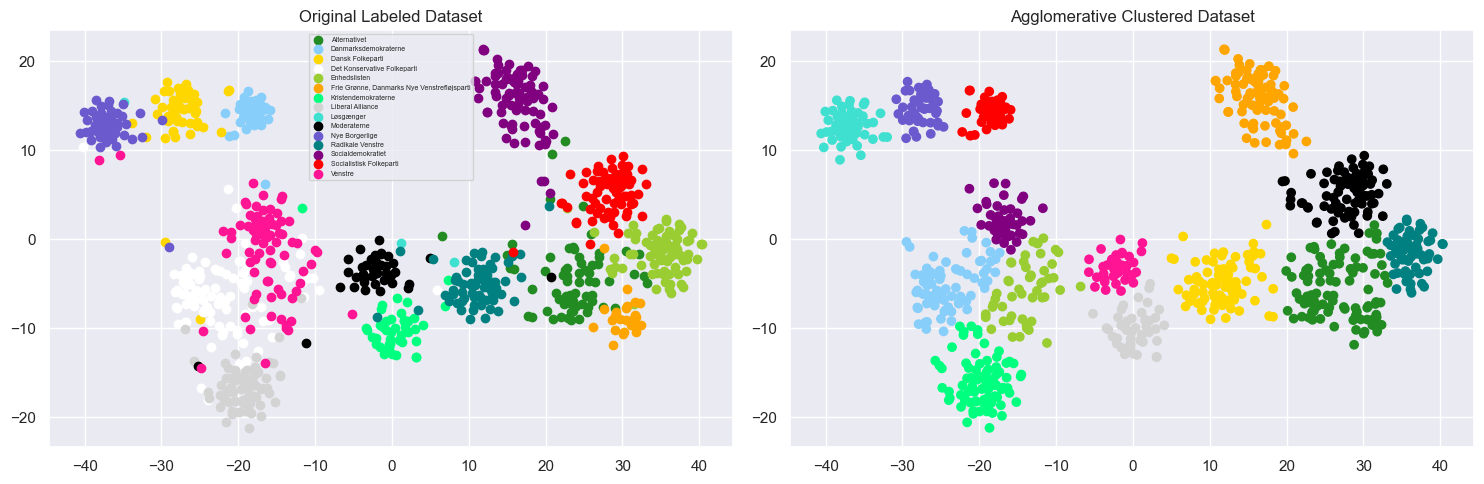

In [41]:
plot_labeled_vs_agg(politcal_tsne, labels, 14, 'ward')

Agglomerative Clustering also did a pretty good job at clustering the t-SNE reduced data, but made the same mistakes as k-means: it made a sub-party out of the mix between Venstre & Det Konservative Folkeparti (the one at (x=-10, y=-5)) and failed to find the small party at (x=30, y=-10) (Frie Grønne). (And if you recall just now, PCA also exterminated Frie Grønne) Could DBSCAN be the one to find this party?

### Agglomerative Clustering Summary

After doing our analysis of Agglomerative Clustering's performance on PCA and t-SNE reduced data, we would say that it performed extraordinarily on the PCA-reduced data, particularly for clusters of sizes 2 (left vs right) and of size 14 (original number of parties). This could be because PCA's dimensionality reduction into two components makes it remarkably easy for an algorithm such as Agglomerative Clustering to join data points with similar answers into clusters no matter their spatial disposition on the graph! It was quite a sight to behold.

## DBSCAN clustering

For DBSCAN clustering, we started by plotting the graph to find out what could be the ideal k, but it didn't bring much value when we were tuning the hyperparameters so we deleted that part of the code.

In [42]:
def plot_dbscan(X_arrays, eps_values, min_samples_values, colors=None):
    if not isinstance(X_arrays, list):
        X_arrays = [X_arrays]
    if not isinstance(eps_values, list):
        eps_values = [eps_values]
    if not isinstance(min_samples_values, list):
        min_samples_values = [min_samples_values]


    figsize = (20,5)
    if (len(X_arrays) == 1):
        figsize = (10,5)

    fig, axes = plt.subplots(1, len(X_arrays), figsize=figsize)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])  # Convert single axis to numpy array
    for i, (X, eps, min_samples, ax) in enumerate(zip(X_arrays, eps_values, min_samples_values, axes)):
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X)
        k = len(set(labels)) - (1 if -1 in labels else 0)  # Number of clusters excluding outliers
        if colors is None:
            colors = plt.cm.get_cmap('tab10', k)
        for label, color in zip(range(k), colors):
            ax.plot(X[labels == label, 0], X[labels == label, 1], '.', markersize=10, label=label, color=color)
        ax.plot(X[labels == -1, 0], X[labels == -1, 1], 'sk', markersize=2, label=-1)  # Plot outliers as black squares
        ax.legend()
    plt.show()


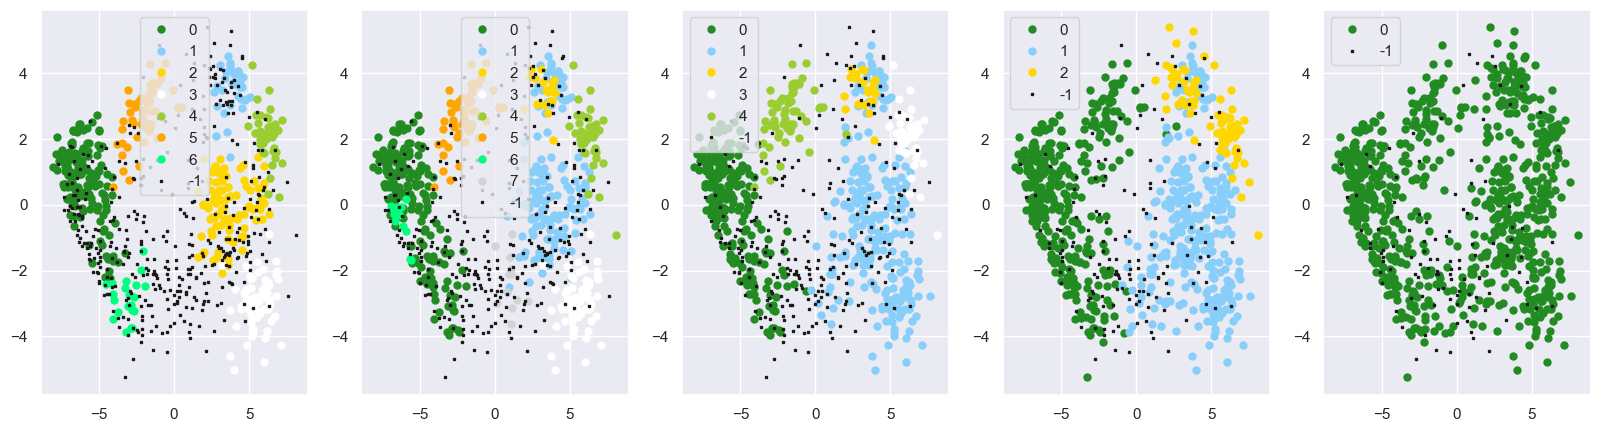

In [43]:
# Try to get some number of clusters
plot_dbscan([X_pca, X_pca, X_pca, X_pca, X_pca], [2.4, 2.5, 2.6, 2.8, 2.9], [15, 15, 15, 15, 15], box_colors)

No matter how much we change the hyperparameters, DBSCAN is just awful for the PCA dimensionality reduction due to the high density of points all over... It either has A LOT of outliers or just merges everything into one ginormous cluster. 

The best output we managed to get was the one of the left-most side.

Let's compare it to the original labeled dataset and see what we can conclude!


/var/folders/80/jw9prfq16355zr9s7gw_ylqh0000gn/T/ipykernel_11590/2878639330.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(X[cluster_labels == label, 0], X[cluster_labels == label, 1], 'sk', markersize=2, label='Outliers', color='black')


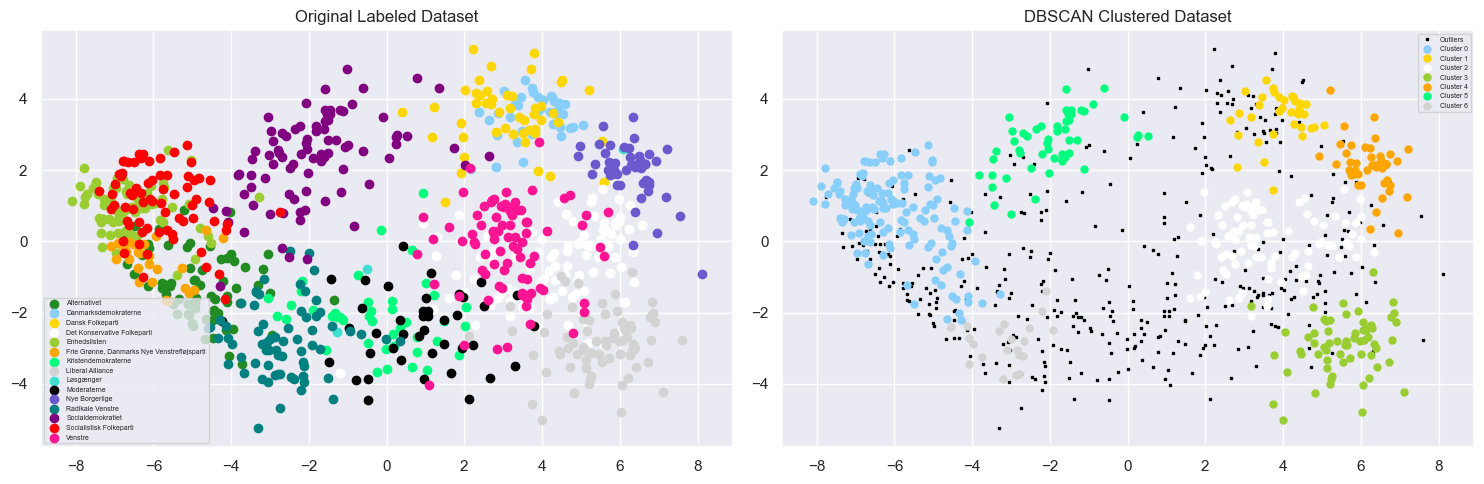

In [44]:
def plot_labeled_vs_dbscan(X, original_labels, eps, min_samples, original_colors=None):
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    # Plot original labeled dataset
    ax1 = axes[0]
    for label, color in zip(np.unique(original_labels), original_colors):
        ax1.scatter(X[original_labels == label, 0], X[original_labels == label, 1], label=label, color=color)
    ax1.set_title('Original Labeled Dataset')
    ax1.legend(fontsize=5)

    # Perform DBSCAN clustering
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(X)

    # Plot DBSCAN clustered dataset
    ax2 = axes[1]
    unique_labels = np.unique(cluster_labels)
    for label, color in zip(unique_labels, original_colors):
        if label == -1:
            ax2.plot(X[cluster_labels == label, 0], X[cluster_labels == label, 1], 'sk', markersize=2, label='Outliers', color='black')
        else:
            ax2.plot(X[cluster_labels == label, 0], X[cluster_labels == label, 1], '.', markersize=10, label='Cluster '+str(label), color=color)
    ax2.legend()
    ax2.set_title('DBSCAN Clustered Dataset')
    ax2.legend(fontsize=5)

    plt.tight_layout()
    plt.show()



plot_labeled_vs_dbscan(X_pca, labels, 2.4, 15, box_colors)

Let's see.
Taking a quick look, DBSCAN performed terribly with the PCA-reduced data.

Successes:
It managed to find and kind-of successfully cluster these parties:
- Socialdemokratier
- Danmarksdemokraterne
- Nye Borgerlige
- Liberal Alliance

But it completely butchers the rest. It either groups a lot of parties into one massive cluster or just deems almost an entire party as a bunch of outliers. For this reason, we conclude that DBSCAN is a terrible solution for PCA-reduced data - at least for the data that we have.


Let's try it on the t-SNE graph though.

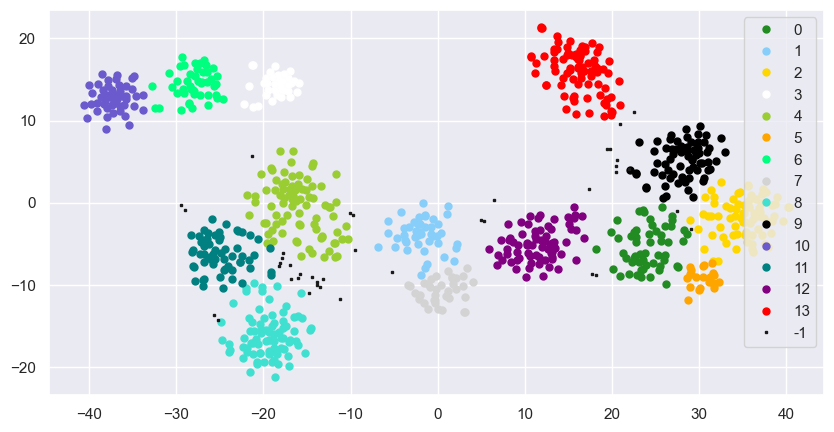

In [45]:
plot_dbscan([politcal_tsne], [3.3], [24], box_colors)

Iiiincredible!!!! As expected, since t-SNE formed dense clusters with the datapoints, preserving the distance & closeness between them, DBSCAN performed outstandingly in the data reduced this way!!! Of course, it took a bit of trial and error to find the good hyperparameters, but this result is phenomenal - DBSCAN even managed to find the little cluster in the corner (x=30, y=-10) (Frie Grønne) that the other clustering algorithms couldn't find!!! 

Let's just plot it side-by-side with the original data to get a good view of how good this is.

/var/folders/80/jw9prfq16355zr9s7gw_ylqh0000gn/T/ipykernel_11590/2878639330.py:19: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "sk" (-> color='k'). The keyword argument will take precedence.
  ax2.plot(X[cluster_labels == label, 0], X[cluster_labels == label, 1], 'sk', markersize=2, label='Outliers', color='black')


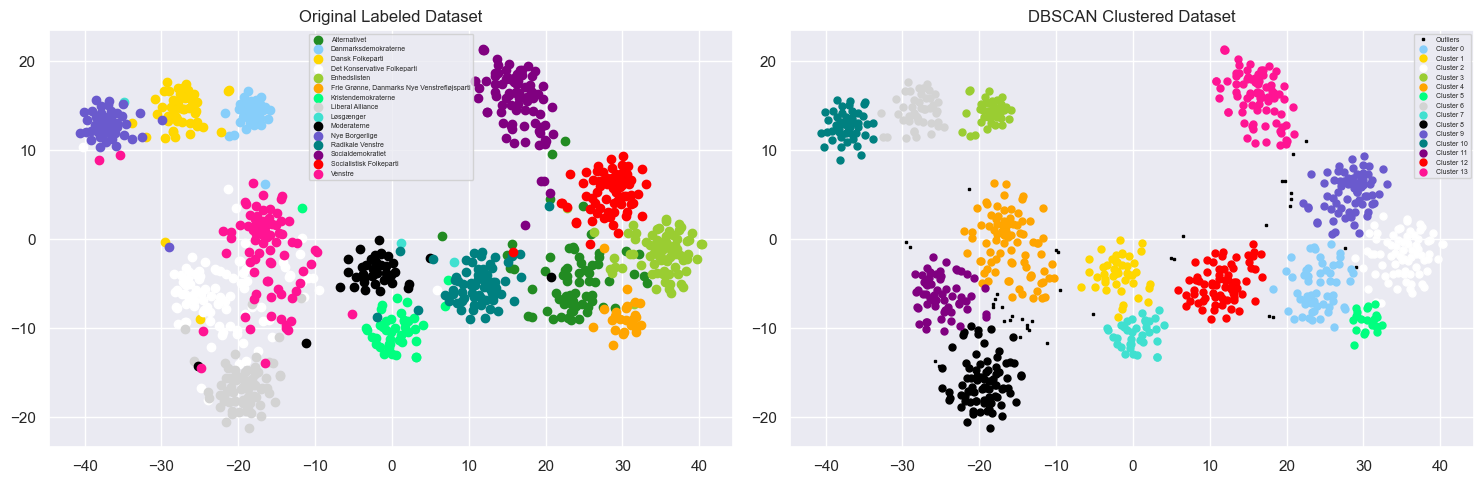

In [46]:
plot_labeled_vs_dbscan(politcal_tsne, labels, 3.3, 24, box_colors)

Isn't that marvelous!
DBSCAN managed to find all the party clusters extremely accurately - including finding the small Frie Grønne cluster and not mixing up Venstre and Det Konservative Folkeparti - two mistakes that both the other clustering algorithms had made.

## Clustering conclusions

After all that clustering, what conclusions may we reach? Well:

- A combination of dimensionality reduction + clustering (t-SNE and DBSCAN in particular) are still able to correctly cluster the Danish political parties without knowing their labels, proving that, despite some parties being very similar to each other, there is still a tangible difference between them - so much so that a machine was able to find patterns that link the candidates of a party together and distinguish the political parties from each other.
- Still, particularly in the Agglomerative Clustering step, we saw that there is a very sharp difference between Right and Left party candidates!!! And while we were at it, we found that maybe Kristendemokraterne and Moderaterne may belong on the left side of the political spectrum and not the right side...

After this analysis, we would say that there is no need for a reduction nor an augmentation of the number of political parties in Denmark - there is enough tangible difference between their ideals that a machine can "blindly find" the parties surprisingly accurately. But there could definitely be some re-arranging of individual candidates to be moved to a party that actually aligns with their ideals!! Because looking at the graphs with the original labels, we see that there are a couple of strays answering the questions differently from their party of origin.

# Disagreements between elected candidates

Lets's take a look at the disagreements within the elected candidates. For that I will reuse the method from the first assignment on the candidates. This method calculates the distances between each candidates.

In [47]:
elected_df = pd.read_excel('electeddata.xlsx')
data_only_questions_and_parti = elected_df.drop(['navn', 'alder', 'storkreds'], axis=1)
data3 = data_only_questions_and_parti.drop(['parti'], axis=1)

total_differences = []

# This function calculates differences between each of the candidates (1st to 2nd, 1st to 3rd... etc.)           
def differenceCalculator(data):
    n = len(data)
    # Pre-calculate properties to avoid repeated function calls
    properties = {'navn': elected_df['navn'], 'parti': elected_df['parti']}
    
    for i in range(n):
        person1 = data.iloc[i]
        name1, party1 = properties['navn'][i], properties['parti'][i]
        for j in range(i + 1, n):
            person2 = data.iloc[j]
            name2, party2 = properties['navn'][j], properties['parti'][j]
            # In this line we subtract each question and then sum those differences
            # absoluteValue of (-1-2) = 3 and so on... (don't agree - strongly agree)
            difference = abs(person1 - person2).sum() 
            total_differences.append((i, j, name1, name2, party1, party2, difference))
    return total_differences

differenceCalculator(data3)

# Convert the list of differences to DataFrame
differences_df = pd.DataFrame(total_differences, columns=['id1', 'id2','candidate1','candidate2', 'parti1', 'parti2', 'totalDifference'])


Okay, now let's consider the interparty disagreements.

In [48]:
differences_df.sort_values(by='totalDifference', ascending=False).head(10)

id1  id2                  candidate1                  candidate2  \
6651    45  127             Peder Hvelplund    Sandra Elisabeth Skalvig   
5356    35  107             Ole Birk Olesen  Karina Lorentzen Dehnhardt   
6669    45  145             Peder Hvelplund             Steffen Frølund   
6630    45  106             Peder Hvelplund                 Henrik Dahl   
2434    15   35     Charlotte Broman Mølbæk             Ole Birk Olesen   
12324  107  127  Karina Lorentzen Dehnhardt    Sandra Elisabeth Skalvig   
6684    45  160             Peder Hvelplund              Steffen Larsen   
6633    45  109             Peder Hvelplund       Niels Flemming Hansen   
6598    45   74             Peder Hvelplund                 Mai Mercado   
5294    35   45             Ole Birk Olesen             Peder Hvelplund   

                        parti1                       parti2  totalDifference  
6651              Enhedslisten             Liberal Alliance              141  
5356          Liberal Alliance      Socialistisk Folkeparti              140  
6669              Enhedslisten             Liberal Alliance              140  
6630              Enhedslisten             Liberal Alliance              140  
2434   Socialistisk Folkeparti             Liberal Alliance              139  
12324  Socialistisk Folkeparti             Liberal Alliance              139  
6684              Enhedslisten             Liberal Alliance              139  
6633              Enhedslisten  Det Konservative Folkeparti              138  
6598              Enhedslisten  Det Konservative Folkeparti              138  
5294          Liberal Alliance                 Enhedslisten              138

Peter Hvelplund seems to be the person that is the most disagreed with. This is also no surprise that the most conservative left wing party has a lot of disagreements with right wing parties.

How about internal disagreements?

In [49]:
diff_intra = differences_df[differences_df['parti1'] == differences_df['parti2']]
display(diff_intra.sort_values(by='totalDifference', ascending=False).head(10)) 

id1  id2                candidate1              candidate2  \
6355    43   78           Mette Reissmann       Bjørn Brandenborg   
5063    33   81     Jon Læssøe Stephensen               Jeppe Søe   
6430    43  153           Mette Reissmann   Fie Thorsted Hækkerup   
6410    43  133           Mette Reissmann            Frederik Vad   
12839  116  138         Benny Engelbrecht          Mette Gjerskov   
6338    43   61           Mette Reissmann          Simon Kollerup   
5086    33  104     Jon Læssøe Stephensen         Henrik Frandsen   
5107    33  125     Jon Læssøe Stephensen  Charlotte Bagge Hansen   
12867  116  166         Benny Engelbrecht           Maria Durhuus   
6517    44  116  Ida Margrete Meier Auken       Benny Engelbrecht   

                  parti1             parti2  totalDifference  
6355   Socialdemokratiet  Socialdemokratiet               77  
5063         Moderaterne        Moderaterne               70  
6430   Socialdemokratiet  Socialdemokratiet               70  
6410   Socialdemokratiet  Socialdemokratiet               69  
12839  Socialdemokratiet  Socialdemokratiet               69  
6338   Socialdemokratiet  Socialdemokratiet               68  
5086         Moderaterne        Moderaterne               68  
5107         Moderaterne        Moderaterne               67  
12867  Socialdemokratiet  Socialdemokratiet               67  
6517   Socialdemokratiet  Socialdemokratiet               67

Metter Reissmann from Socialdemokratiet has a lot of dissagrements with various colleagues from her party. This is also the case for Jon Laessoee Stephensen in Moderaterne. Those two parties seems to have high degree of internal disagreements.

What about the candidates from different parties that agree the most?

In [50]:
diff_inter = differences_df[differences_df['parti1'] != differences_df['parti2']]
display(diff_inter.sort_values(by='totalDifference', ascending=True).head(10)) 

id1  id2            candidate1            candidate2  \
211     1   45          Torsten Gejl       Peder Hvelplund   
4473   29   37        Pelle Dragsted         Carl Valentin   
44      0   45         Karsten Hønge       Peder Hvelplund   
5760   38  118  Lisbeth Bech-Nielsen     Trine Pertou Mach   
1       0    2         Karsten Hønge         Mai Villadsen   
369     2   37         Mai Villadsen         Carl Valentin   
493     2  161         Mai Villadsen       Sigurd Agersnap   
346     2   14         Mai Villadsen         Sofie Lippert   
370     2   38         Mai Villadsen  Lisbeth Bech-Nielsen   
94      0   95         Karsten Hønge  Søren Egge Rasmussen   

                       parti1                   parti2  totalDifference  
211              Alternativet             Enhedslisten               15  
4473             Enhedslisten  Socialistisk Folkeparti               19  
44    Socialistisk Folkeparti             Enhedslisten               19  
5760  Socialistisk Folkeparti             Enhedslisten               19  
1     Socialistisk Folkeparti             Enhedslisten               19  
369              Enhedslisten  Socialistisk Folkeparti               20  
493              Enhedslisten  Socialistisk Folkeparti               20  
346              Enhedslisten  Socialistisk Folkeparti               20  
370              Enhedslisten  Socialistisk Folkeparti               20  
94    Socialistisk Folkeparti             Enhedslisten               20

The left wing parties have the most in common, in particular Enhedslisten and Socialist Folkeparti. Mai Villadsen is a person that agrees with 5 candidates from Socialistisk Folkeparti. That could suggest that she might be in that party instead. If you take a look at the PCA plot it can also be seen there that those two parties have a lot in common.

And finally how about the highest degree of internal agreements?

In [51]:
differences_df.sort_values(by='totalDifference', ascending=True).head(10)

id1  id2             candidate1               candidate2  \
8924    65  150           Lea Wermelin          Rasmus Stoklund   
12387  108  130       Pernille Vermund  Peter Seier Christensen   
7829    55  130             Kim Edberg  Peter Seier Christensen   
10349   80  150          Trine Bramsen          Rasmus Stoklund   
7807    55  108             Kim Edberg         Pernille Vermund   
8854    65   80           Lea Wermelin            Trine Bramsen   
1142     6  156  Jakob Ellemann-Jensen           Karen Ellemann   
13858  142  156           Sophie Løhde           Karen Ellemann   
10848   86  142       Thomas Danielsen             Sophie Løhde   
10862   86  156       Thomas Danielsen           Karen Ellemann   

                  parti1             parti2  totalDifference  
8924   Socialdemokratiet  Socialdemokratiet                1  
12387     Nye Borgerlige     Nye Borgerlige                1  
7829      Nye Borgerlige     Nye Borgerlige                2  
10349  Socialdemokratiet  Socialdemokratiet                2  
7807      Nye Borgerlige     Nye Borgerlige                3  
8854   Socialdemokratiet  Socialdemokratiet                3  
1142             Venstre            Venstre                3  
13858            Venstre            Venstre                4  
10848            Venstre            Venstre                5  
10862            Venstre            Venstre                5

Those three parties seems to have the least internal disagreements. Candidates from venstre seems to agree a lot as well as candidates from Nye Borgerlige and Socialdemokratiet.